<a href="https://colab.research.google.com/github/Makito042/Summative-Assignment---Model-Training-and-Evaluation-Start-Assignment/blob/main/Untitled24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training and Evaluation on Agricultural Pest Images

This notebook explores the application of both classical machine learning and state-of-the-art deep learning methods for multi-class classification of agricultural pest images.

## Problem Statement

The accurate identification of agricultural pests is critical for improving crop yield and minimizing environmental damage associated with overuse of pesticides. Manual inspection is prone to error and does not scale for large agricultural regions. The goal of this project is to evaluate several modeling strategies for robust automatic pest recognition based on image data.

## Dataset Description

The dataset contains thousands of color images representing 12 different pest classes, collected from a range of agricultural environments. Each image is labeled with its corresponding pest type. The dataset is realistic, varies in quality, and involves challenges such as class imbalance and intra-class variability.

## Workflow Plan

- Conduct thorough data loading, cleaning, and stratified splitting to ensure reproducible experiments.
- Benchmark classical ML models (Logistic Regression, SVM, Random Forest) on extracted or flattened features.
- Design and train baseline CNN and custom CNN architectures from scratch to establish deep learning baselines.
- Apply transfer learning (VGG16 and MobileNetV2), including fine-tuning, to leverage high-level feature representations.
- Evaluate each model using accuracy, precision, recall, F1 score, validation curves, confusion matrices, and ROC curves.
- Summarize results in comparative tables and critically discuss limitations, tradeoffs, and real-world implications.

This end-to-end pipeline demonstrates a scientific, evidence-driven approach to pest detection, providing both technical insights and practical recommendations for AI in agricultural applications.

# data source:https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset?resource=download

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

#Library Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Download, unzip, and list dataset.

In [ ]:
# Download the file from Google Drive
!gdown --id 1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU

# Define the target directory
target_dir = '/content/pestpredicition'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Unzip the downloaded file into the target directory
!unzip archive.zip -d {target_dir} >/dev/null 2>&1

# List the contents of the unzipped directory
!ls {target_dir}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU
From (redirected): https://drive.google.com/uc?id=1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU&confirm=t&uuid=5e676e1b-0e87-46ae-a408-20d08ad74eb0
To: /content/archive.zip
100% 107M/107M [00:01<00:00, 62.0MB/s] 
ants  beetle	    earthworms	grasshopper  slug   wasp
bees  catterpillar  earwig	moth	     snail  weevil


In [ ]:
DATA_DIR = '/content/pestpredicition'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
OUTPUT_DIR = '/content/output'

#  1.Data Preprocessing and Splitting

In [ ]:
# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 2. Load and Preprocess Data
def load_and_preprocess_data(data_dir, img_size):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0
                images.append(img)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

print("Loading and preprocessing data...")
images, labels, class_names = load_and_preprocess_data(DATA_DIR, IMG_SIZE)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

# --- Split Data ---
X_flat = images.reshape(images.shape[0], -1)
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_test, y_train_dl, y_test_dl = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test_dl, y_val_dl, y_test_dl_final = train_test_split(X_test, y_test_dl, test_size=0.5, random_state=42, stratify=y_test_dl)


Loading and preprocessing data...
Loaded 5494 images from 12 classes.


# 2. Visualization Helpers

In [ ]:
def plot_learning_curves(history, model_name, experiment, test_metrics=None):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    if test_metrics:
        plt.axhline(y=test_metrics['accuracy'], color='r', linestyle='--', label=f'Test Accuracy ({test_metrics["accuracy"]:.4f})')
    plt.title(f'{model_name} ({experiment}) - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if test_metrics:
        plt.axhline(y=test_metrics['loss'], color='r', linestyle='--', label=f'Test Loss ({test_metrics["loss"]:.4f})')
    plt.title(f'{model_name} ({experiment}) - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_learning_curves.png'))
    plt.show()
    plt.close()

def plot_confusion_matrix(y_true, y_pred, model_name, experiment):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} ({experiment}) - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_confusion_matrix.png'))
    plt.show()
    plt.close()

def plot_roc_curves(y_true, y_pred_proba, model_name, experiment, n_classes):
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ({experiment}) - ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_roc_curves.png'))
    plt.show()
    plt.close()

def plot_classical_performance_curves(train_metrics, test_metrics, model_name, experiment):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    train_values = [train_metrics[m] for m in metrics]
    test_values = [test_metrics[m] for m in metrics]

    plt.figure(figsize=(10, 6))
    plt.plot(metrics, train_values, marker='o', linestyle='-', label='Train')
    plt.plot(metrics, test_values, marker='o', linestyle='-', label='Test')

    plt.title(f'{model_name} ({experiment}) - Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()

    for i, metric in enumerate(metrics):
        plt.text(i, train_values[i] + 0.02, f'{train_values[i]:.4f}', ha='center')
        plt.text(i, test_values[i] - 0.04, f'{test_values[i]:.4f}', ha='center')

    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_performance_curves.png'))
    plt.show()
    plt.close()

In [ ]:
n_classes = len(class_names)

# 3.Classic Machine Learning Apply Logistic Regression

--- Training Logistic Regression (Exp1) ---
Logistic Regression - Experiment 1 Test Results:
Accuracy: 0.1959, Precision: 0.1886, Recall: 0.1959, F1-score: 0.1906


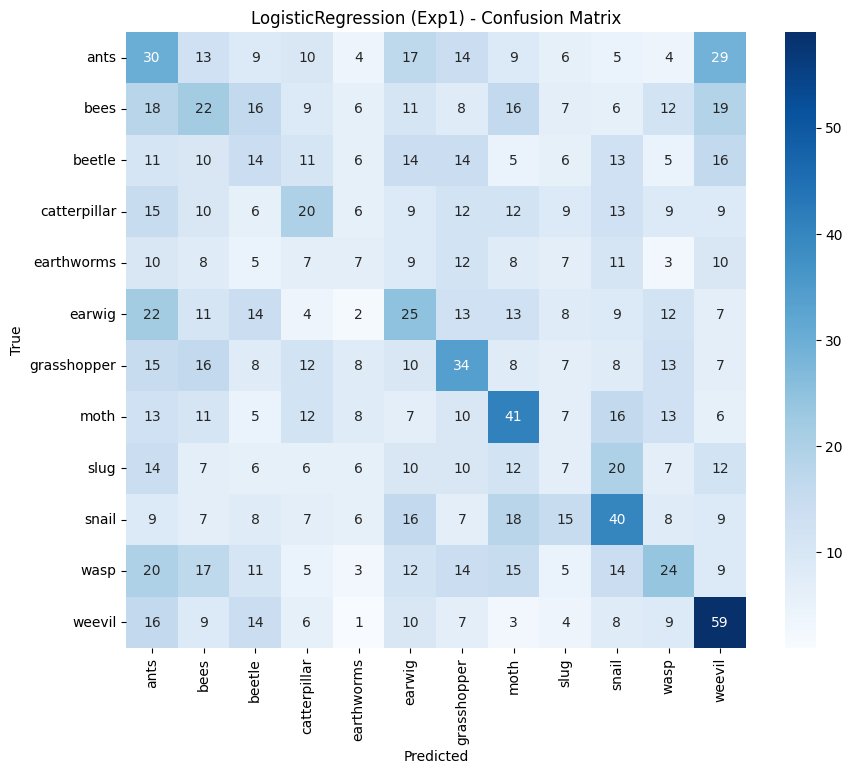

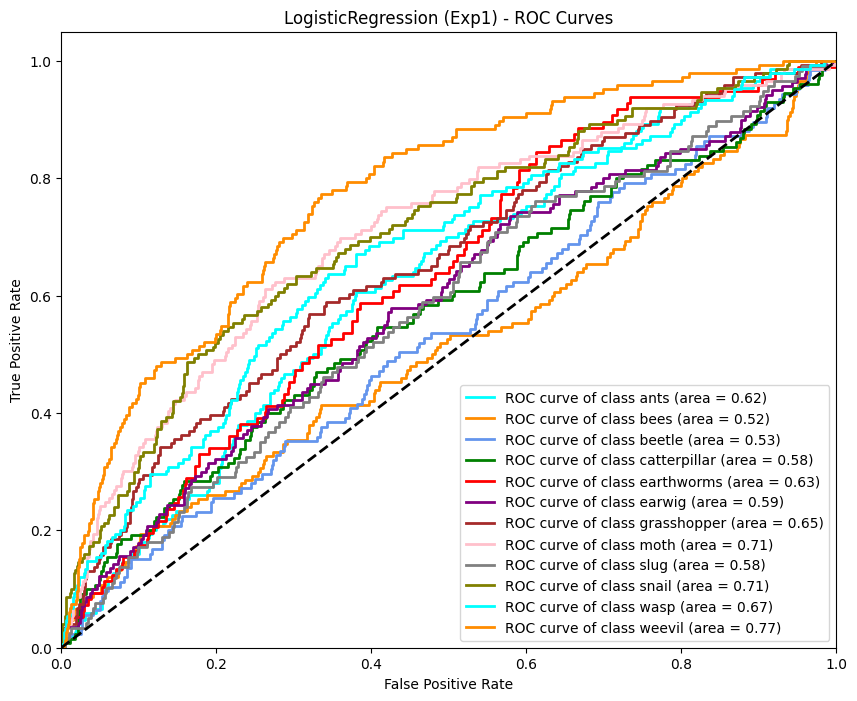

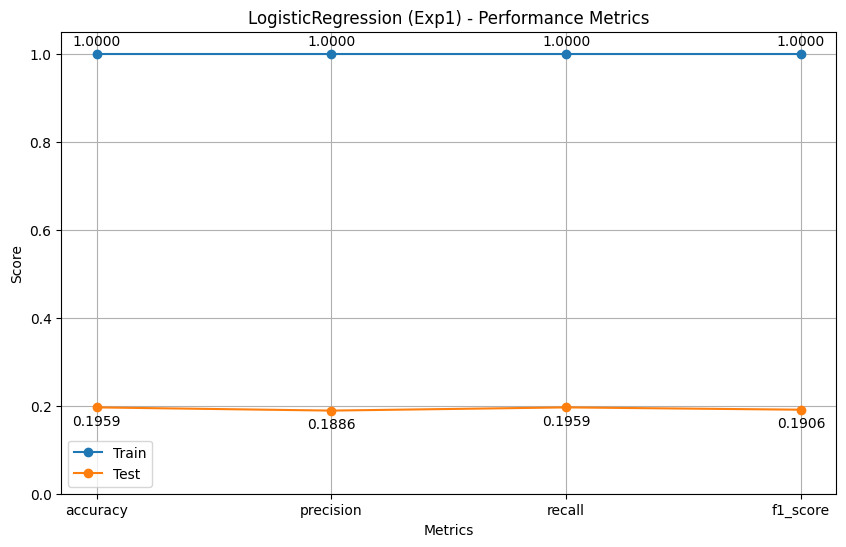

In [ ]:
# --- Logistic Regression ---
# Experiment 1
print("--- Training Logistic Regression (Exp1) ---")
lr1 = LogisticRegression(max_iter=1000, random_state=42)
lr1.fit(X_train_flat, y_train)
# Test metrics
preds1 = lr1.predict(X_test_flat)
pred_proba1 = lr1.predict_proba(X_test_flat)
test_metrics1 = {'accuracy': accuracy_score(y_test, preds1), 'precision': precision_score(y_test, preds1, average='weighted'), 'recall': recall_score(y_test, preds1, average='weighted'), 'f1_score': f1_score(y_test, preds1, average='weighted')}
print("Logistic Regression - Experiment 1 Test Results:")
print(f"Accuracy: {test_metrics1['accuracy']:.4f}, Precision: {test_metrics1['precision']:.4f}, Recall: {test_metrics1['recall']:.4f}, F1-score: {test_metrics1['f1_score']:.4f}")
# Train metrics
train_preds1 = lr1.predict(X_train_flat)
train_metrics1 = {'accuracy': accuracy_score(y_train, train_preds1), 'precision': precision_score(y_train, train_preds1, average='weighted'), 'recall': recall_score(y_train, train_preds1, average='weighted'), 'f1_score': f1_score(y_train, train_preds1, average='weighted')}
plot_confusion_matrix(y_test, preds1, 'LogisticRegression', 'Exp1')
plot_roc_curves(y_test, pred_proba1, 'LogisticRegression', 'Exp1', n_classes)
plot_classical_performance_curves(train_metrics1, test_metrics1, 'LogisticRegression', 'Exp1')


# Classic Machine Learning Apply Logistic Regression Experiment 2


--- Training Logistic Regression (Exp2) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Experiment 2 Test Results:
Accuracy: 0.2013, Precision: 0.1940, Recall: 0.2013, F1-score: 0.1955


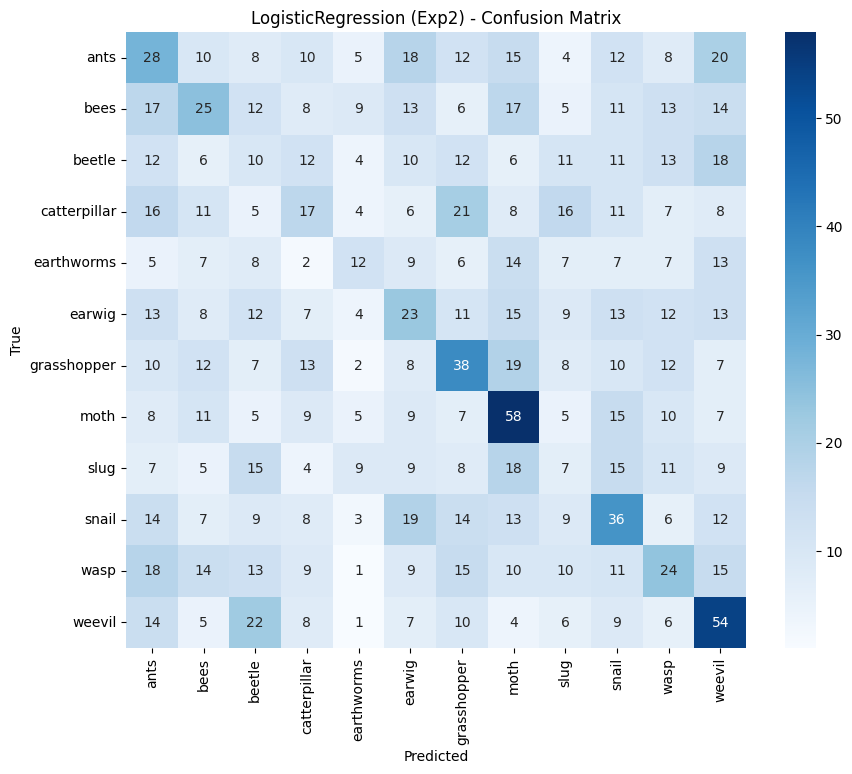

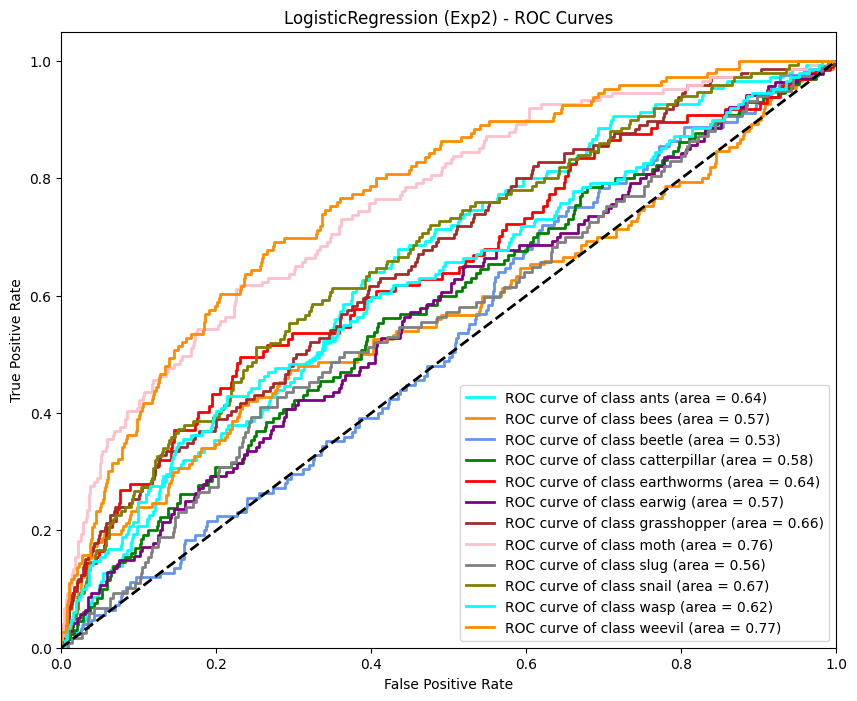

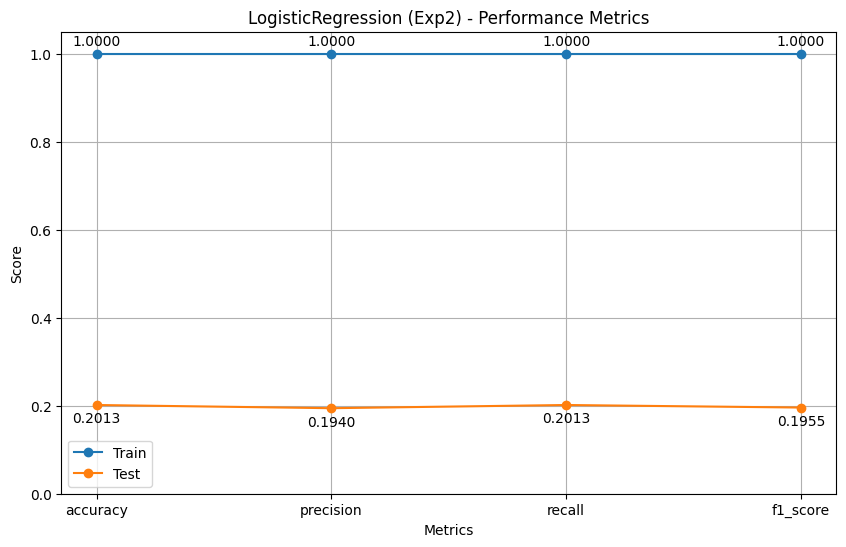

In [ ]:
# Experiment 2
print("\n--- Training Logistic Regression (Exp2) ---")
lr2 = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
lr2.fit(X_train_flat, y_train)
# Test metrics
preds2 = lr2.predict(X_test_flat)
pred_proba2 = lr2.predict_proba(X_test_flat)
test_metrics2 = {'accuracy': accuracy_score(y_test, preds2), 'precision': precision_score(y_test, preds2, average='weighted'), 'recall': recall_score(y_test, preds2, average='weighted'), 'f1_score': f1_score(y_test, preds2, average='weighted')}
print("Logistic Regression - Experiment 2 Test Results:")
print(f"Accuracy: {test_metrics2['accuracy']:.4f}, Precision: {test_metrics2['precision']:.4f}, Recall: {test_metrics2['recall']:.4f}, F1-score: {test_metrics2['f1_score']:.4f}")
# Train metrics
train_preds2 = lr2.predict(X_train_flat)
train_metrics2 = {'accuracy': accuracy_score(y_train, train_preds2), 'precision': precision_score(y_train, train_preds2, average='weighted'), 'recall': recall_score(y_train, train_preds2, average='weighted'), 'f1_score': f1_score(y_train, train_preds2, average='weighted')}
plot_confusion_matrix(y_test, preds2, 'LogisticRegression', 'Exp2')
plot_roc_curves(y_test, pred_proba2, 'LogisticRegression', 'Exp2', n_classes)
plot_classical_performance_curves(train_metrics2, test_metrics2, 'LogisticRegression', 'Exp2')

# 4. Classic Machine Learning SVM Experiment 3


--- Training SVM (Exp1) ---
SVM - Experiment 1 Test Results:
Accuracy: 0.2838, Precision: 0.2848, Recall: 0.2838, F1-score: 0.2682


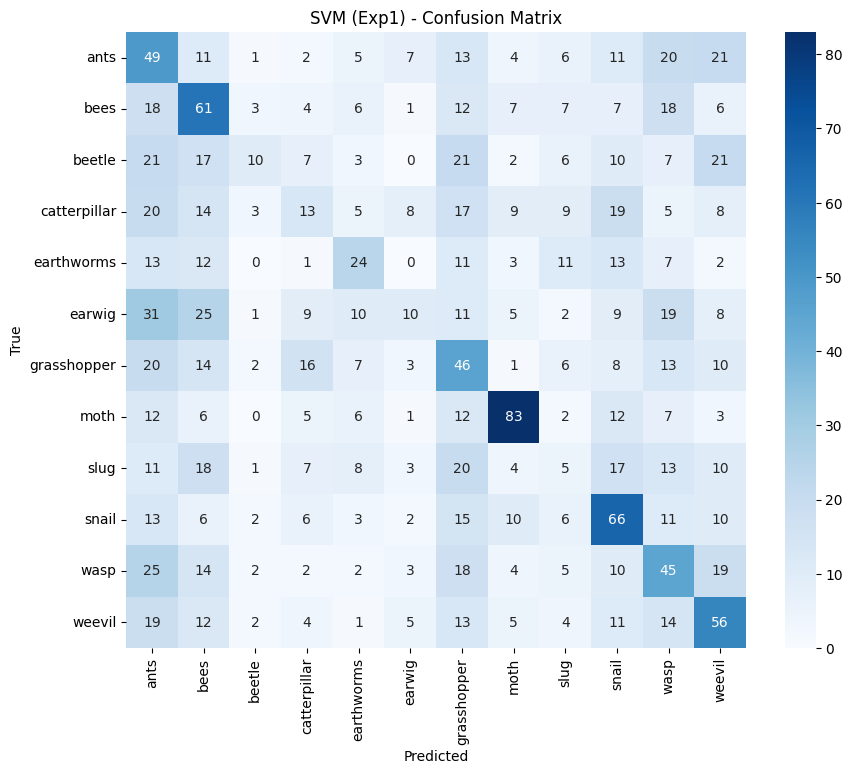

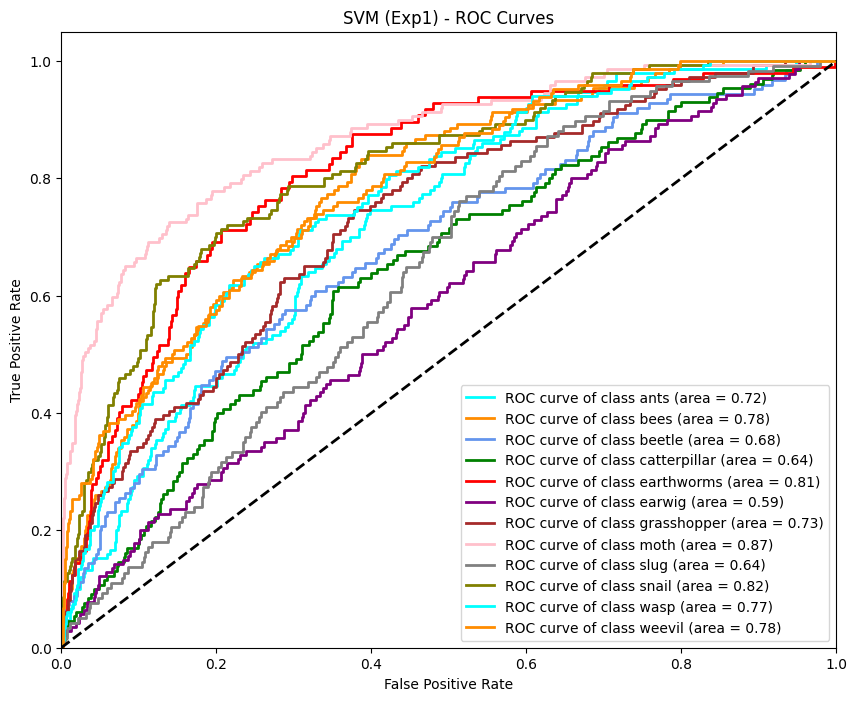

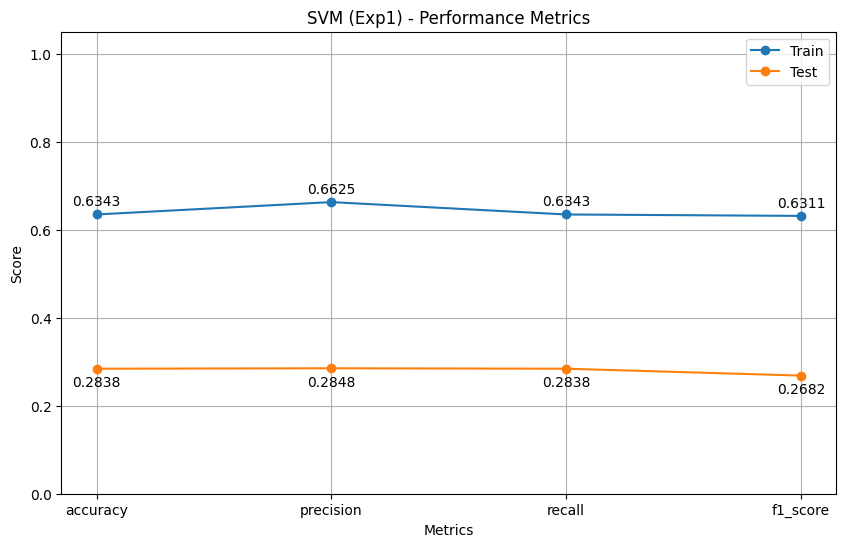

In [ ]:
# --- Support Vector Machine (SVM) ---
# Experiment 1
print("\n--- Training SVM (Exp1) ---")
svm1 = SVC(kernel='rbf', probability=True, random_state=42)
svm1.fit(X_train_flat, y_train)
# Test metrics
preds1 = svm1.predict(X_test_flat)
pred_proba1 = svm1.predict_proba(X_test_flat)
test_metrics1 = {'accuracy': accuracy_score(y_test, preds1), 'precision': precision_score(y_test, preds1, average='weighted'), 'recall': recall_score(y_test, preds1, average='weighted'), 'f1_score': f1_score(y_test, preds1, average='weighted')}
print("SVM - Experiment 1 Test Results:")
print(f"Accuracy: {test_metrics1['accuracy']:.4f}, Precision: {test_metrics1['precision']:.4f}, Recall: {test_metrics1['recall']:.4f}, F1-score: {test_metrics1['f1_score']:.4f}")
# Train metrics
train_preds1 = svm1.predict(X_train_flat)
train_metrics1 = {'accuracy': accuracy_score(y_train, train_preds1), 'precision': precision_score(y_train, train_preds1, average='weighted'), 'recall': recall_score(y_train, train_preds1, average='weighted'), 'f1_score': f1_score(y_train, train_preds1, average='weighted')}
plot_confusion_matrix(y_test, preds1, 'SVM', 'Exp1')
plot_roc_curves(y_test, pred_proba1, 'SVM', 'Exp1', n_classes)
plot_classical_performance_curves(train_metrics1, test_metrics1, 'SVM', 'Exp1')


# Classic Machine Learning SVM Experiment 4


--- Training SVM (Exp2) ---
SVM - Experiment 2 Test Results:
Accuracy: 0.2207, Precision: 0.2269, Recall: 0.2207, F1-score: 0.2201


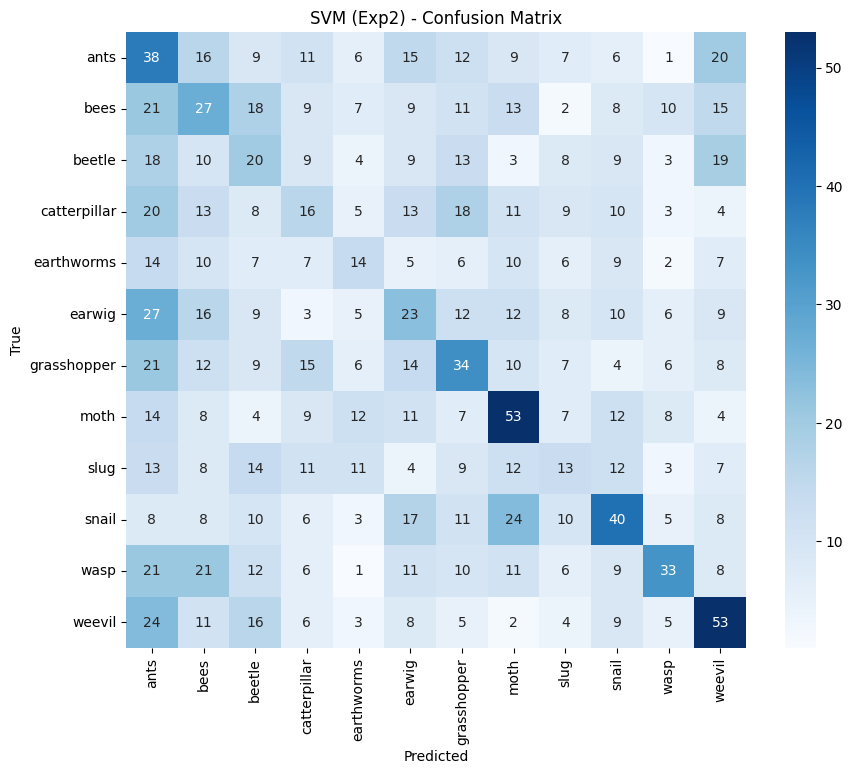

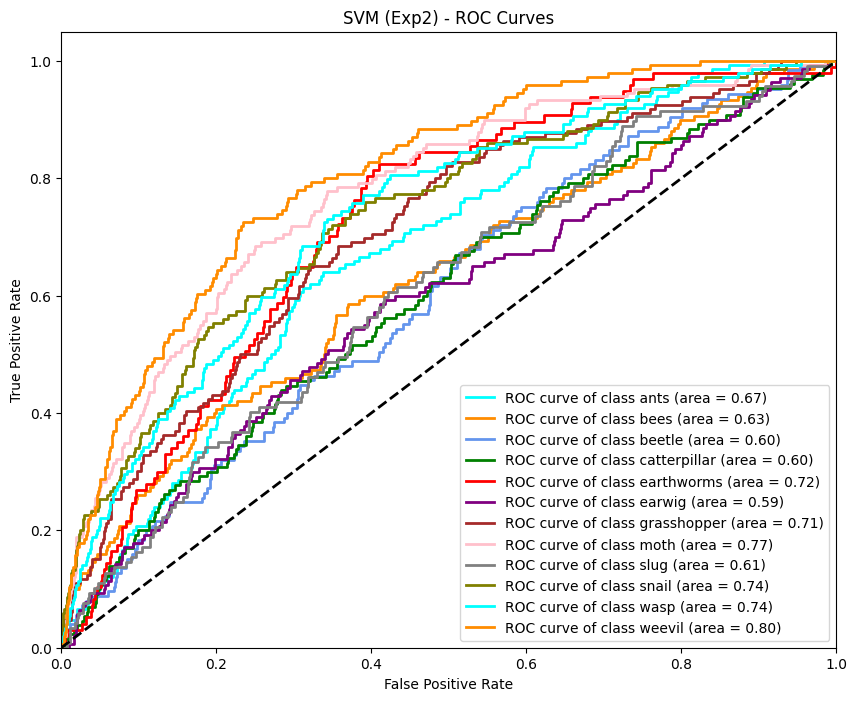

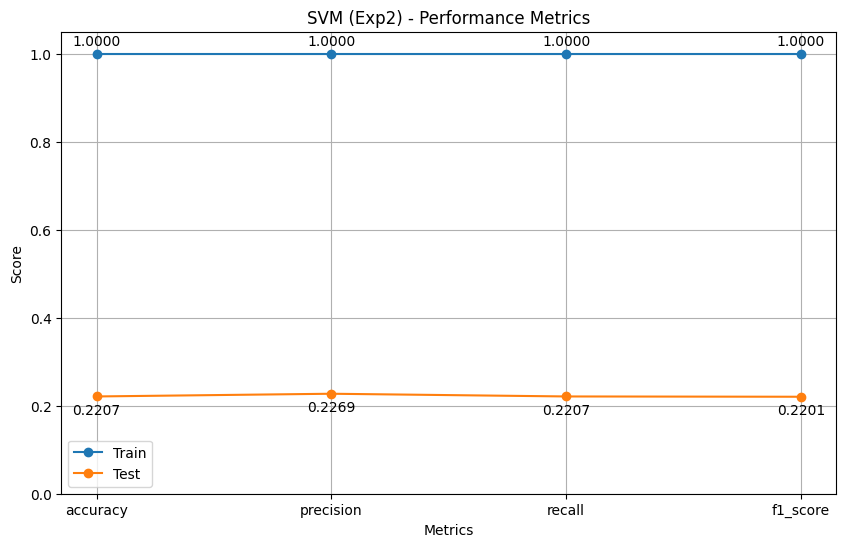

In [ ]:
# Experiment 2
print("\n--- Training SVM (Exp2) ---")
svm2 = SVC(kernel='linear', probability=True, random_state=42)
svm2.fit(X_train_flat, y_train)
# Test metrics
preds2 = svm2.predict(X_test_flat)
pred_proba2 = svm2.predict_proba(X_test_flat)
test_metrics2 = {'accuracy': accuracy_score(y_test, preds2), 'precision': precision_score(y_test, preds2, average='weighted'), 'recall': recall_score(y_test, preds2, average='weighted'), 'f1_score': f1_score(y_test, preds2, average='weighted')}
print("SVM - Experiment 2 Test Results:")
print(f"Accuracy: {test_metrics2['accuracy']:.4f}, Precision: {test_metrics2['precision']:.4f}, Recall: {test_metrics2['recall']:.4f}, F1-score: {test_metrics2['f1_score']:.4f}")
# Train metrics
train_preds2 = svm2.predict(X_train_flat)
train_metrics2 = {'accuracy': accuracy_score(y_train, train_preds2), 'precision': precision_score(y_train, train_preds2, average='weighted'), 'recall': recall_score(y_train, train_preds2, average='weighted'), 'f1_score': f1_score(y_train, train_preds2, average='weighted')}
plot_confusion_matrix(y_test, preds2, 'SVM', 'Exp2')
plot_roc_curves(y_test, pred_proba2, 'SVM', 'Exp2', n_classes)
plot_classical_performance_curves(train_metrics2, test_metrics2, 'SVM', 'Exp2')

# 5. Classic Machine Learning Random Forest Experiment 5


--- Training Random Forest (Exp1) ---
Random Forest - Experiment 1 Test Results:
Accuracy: 0.2674, Precision: 0.2565, Recall: 0.2674, F1-score: 0.2530


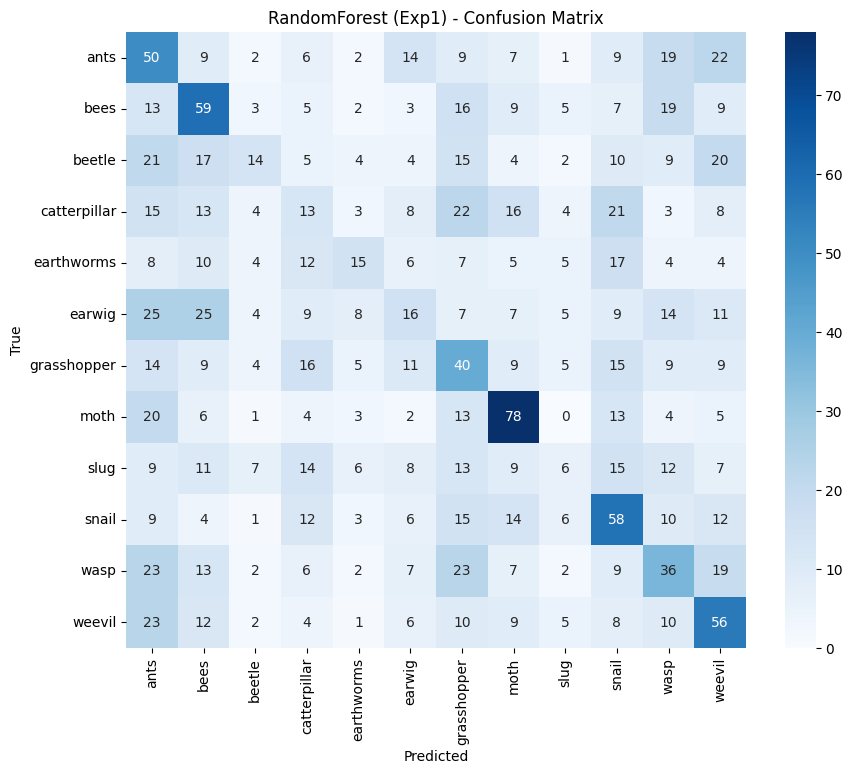

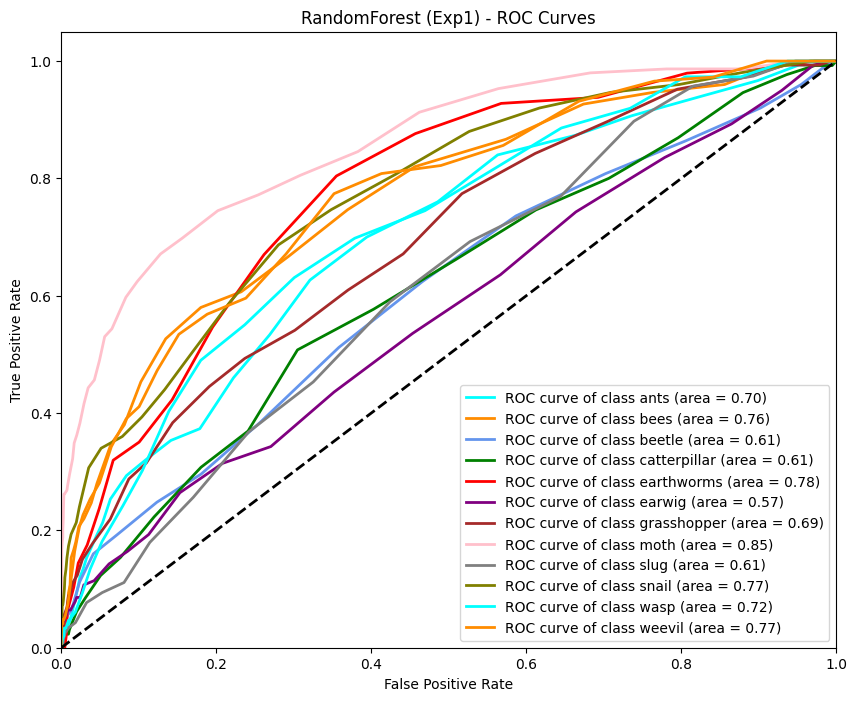

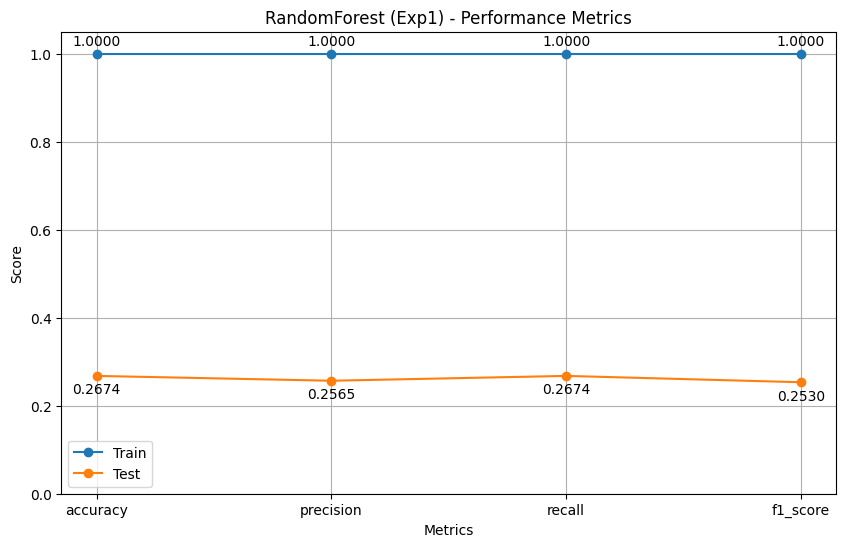

In [ ]:
# --- Random Forest ---
# Experiment 1
print("\n--- Training Random Forest (Exp1) ---")
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train_flat, y_train)
# Test metrics
preds1 = rf1.predict(X_test_flat)
pred_proba1 = rf1.predict_proba(X_test_flat)
test_metrics1 = {'accuracy': accuracy_score(y_test, preds1), 'precision': precision_score(y_test, preds1, average='weighted'), 'recall': recall_score(y_test, preds1, average='weighted'), 'f1_score': f1_score(y_test, preds1, average='weighted')}
print("Random Forest - Experiment 1 Test Results:")
print(f"Accuracy: {test_metrics1['accuracy']:.4f}, Precision: {test_metrics1['precision']:.4f}, Recall: {test_metrics1['recall']:.4f}, F1-score: {test_metrics1['f1_score']:.4f}")
# Train metrics
train_preds1 = rf1.predict(X_train_flat)
train_metrics1 = {'accuracy': accuracy_score(y_train, train_preds1), 'precision': precision_score(y_train, train_preds1, average='weighted'), 'recall': recall_score(y_train, train_preds1, average='weighted'), 'f1_score': f1_score(y_train, train_preds1, average='weighted')}
plot_confusion_matrix(y_test, preds1, 'RandomForest', 'Exp1')
plot_roc_curves(y_test, pred_proba1, 'RandomForest', 'Exp1', n_classes)
plot_classical_performance_curves(train_metrics1, test_metrics1, 'RandomForest', 'Exp1')

#  Classic Machine Learning Random Forest Experiment 6


--- Training Random Forest (Exp2) ---
Random Forest - Experiment 2 Test Results:
Accuracy: 0.2941, Precision: 0.2777, Recall: 0.2941, F1-score: 0.2740


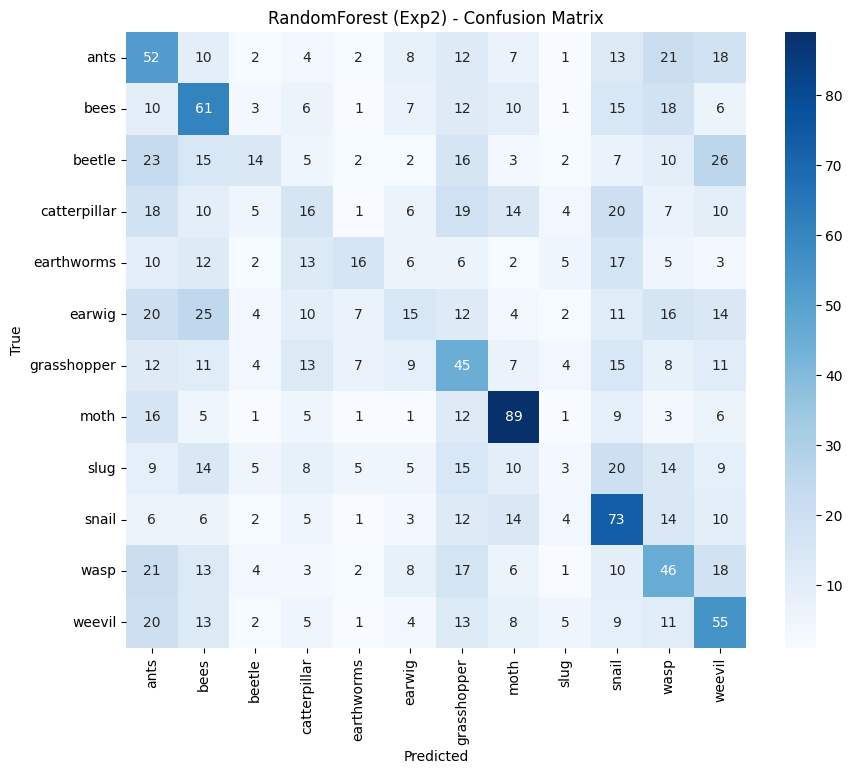

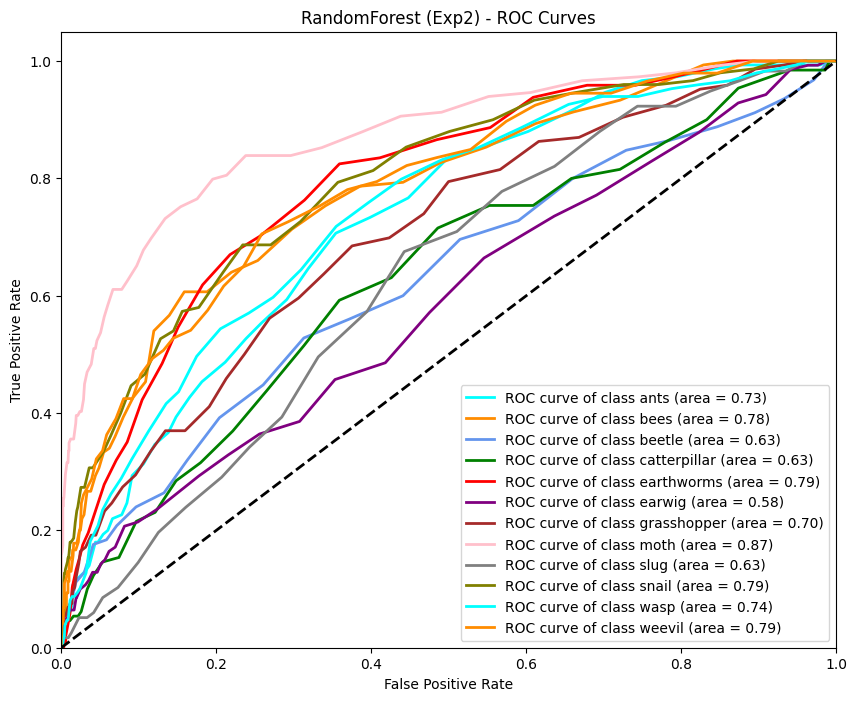

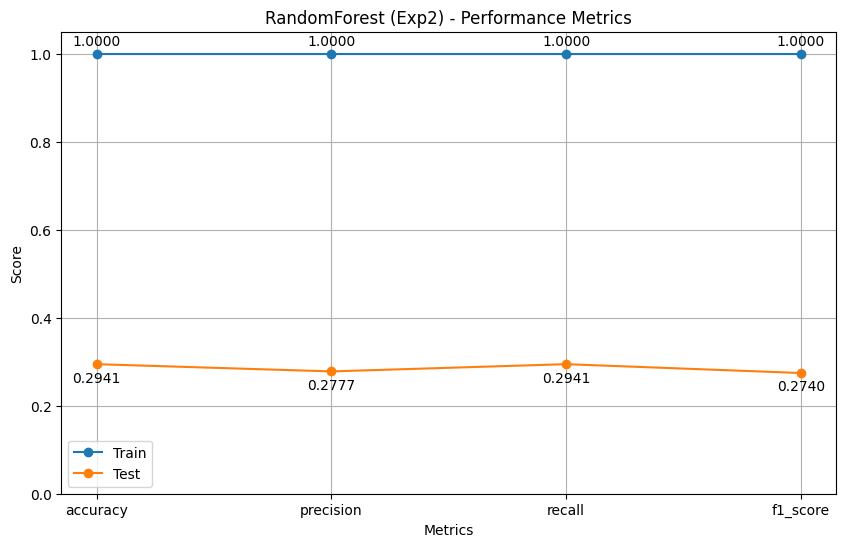

In [ ]:
# Experiment 2
print("\n--- Training Random Forest (Exp2) ---")
rf2 = RandomForestClassifier(n_estimators=200, random_state=42)
rf2.fit(X_train_flat, y_train)
# Test metrics
preds2 = rf2.predict(X_test_flat)
pred_proba2 = rf2.predict_proba(X_test_flat)
test_metrics2 = {'accuracy': accuracy_score(y_test, preds2), 'precision': precision_score(y_test, preds2, average='weighted'), 'recall': recall_score(y_test, preds2, average='weighted'), 'f1_score': f1_score(y_test, preds2, average='weighted')}
print("Random Forest - Experiment 2 Test Results:")
print(f"Accuracy: {test_metrics2['accuracy']:.4f}, Precision: {test_metrics2['precision']:.4f}, Recall: {test_metrics2['recall']:.4f}, F1-score: {test_metrics2['f1_score']:.4f}")
# Train metrics
train_preds2 = rf2.predict(X_train_flat)
train_metrics2 = {'accuracy': accuracy_score(y_train, train_preds2), 'precision': precision_score(y_train, train_preds2, average='weighted'), 'recall': recall_score(y_train, train_preds2, average='weighted'), 'f1_score': f1_score(y_train, train_preds2, average='weighted')}
plot_confusion_matrix(y_test, preds2, 'RandomForest', 'Exp2')
plot_roc_curves(y_test, pred_proba2, 'RandomForest', 'Exp2', n_classes)
plot_classical_performance_curves(train_metrics2, test_metrics2, 'RandomForest', 'Exp2')


# 6. Deep Learning Models

In [ ]:
input_shape = X_train[0].shape
num_classes = len(class_names)
y_train_cat = to_categorical(y_train_dl, num_classes)
y_val_cat = to_categorical(y_val_dl, num_classes)
y_test_cat = to_categorical(y_test_dl_final, num_classes)

# 5. Deep Learning Models Simple CNN Experiment 7


--- Training Simple CNN (Exp1) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 93s 750ms/step - accuracy: 0.1231 - loss: 2.8025 - val_accuracy: 0.2063 - val_loss: 2.2401
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 143s 764ms/step - accuracy: 0.3035 - loss: 2.0601 - val_accuracy: 0.3216 - val_loss: 2.0468
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 93s 767ms/step - accuracy: 0.4910 - loss: 1.5694 - val_accuracy: 0.3532 - val_loss: 1.9992
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 148s 814ms/step - accuracy: 0.6765 - loss: 1.0525 - val_accuracy: 0.3471 - val_loss: 2.1847
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 91s 756ms/step - accuracy: 0.8348 - loss: 0.5665 - val_accuracy: 0.3204 - val_loss: 2.5590
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 139s 731ms/step - accuracy: 0.9268 - loss: 0.2982 - val_accuracy: 0.3313 - val_loss: 2.9283
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 90s 744ms/step - accuracy: 0.9663 - loss: 0.1459 - val_accuracy: 0.3398 - val_loss: 3.5913
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 89s 737ms/step - accuracy: 0.9817 - loss

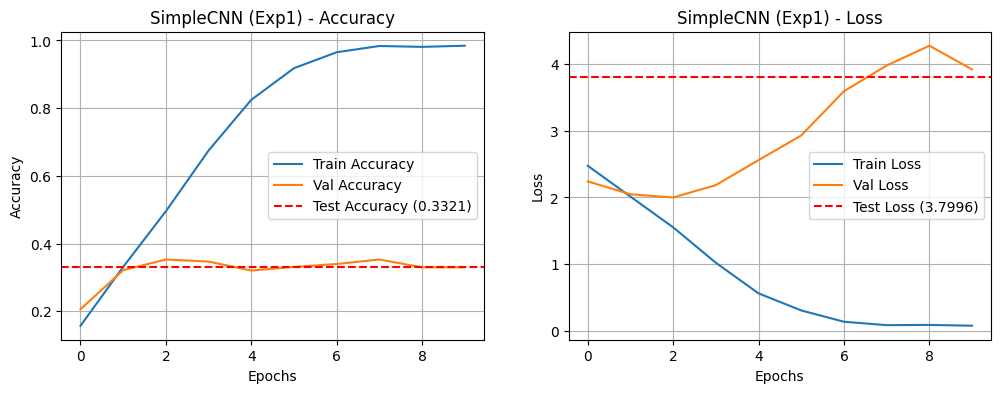

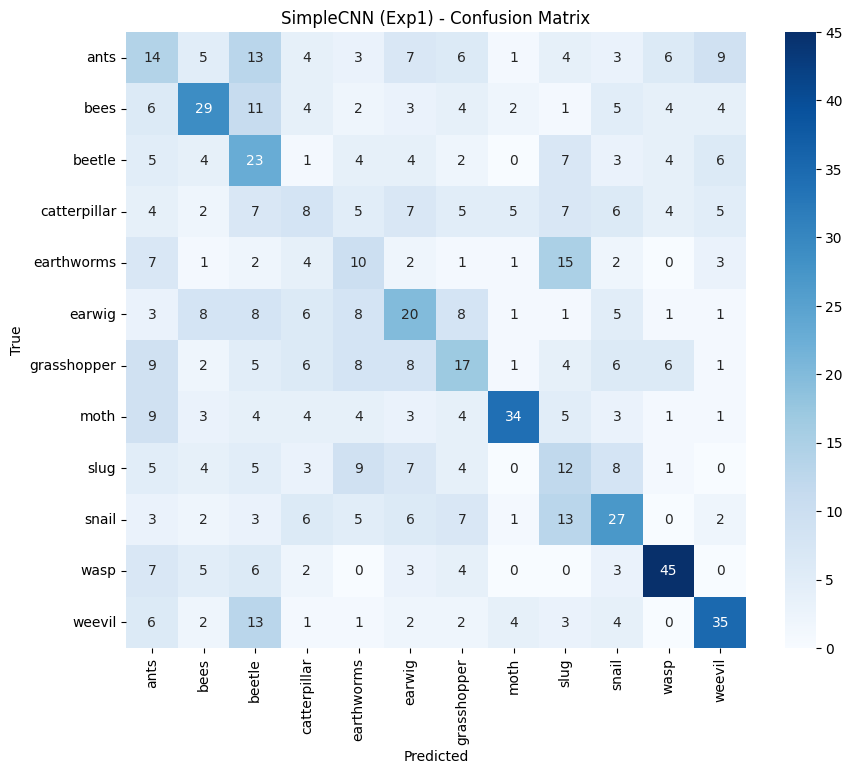

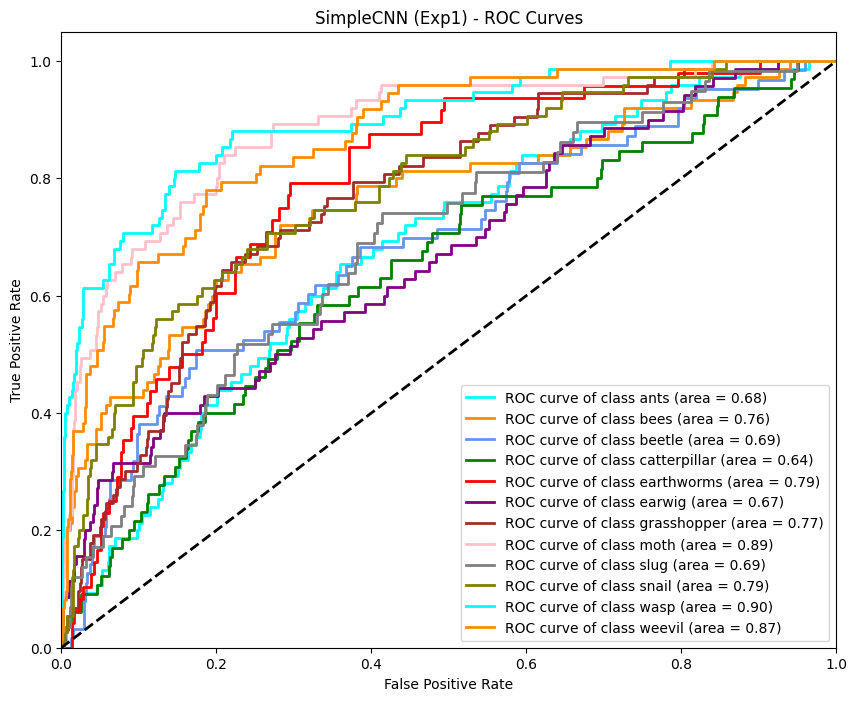

In [ ]:

def create_simple_cnn(input_shape, num_classes):
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'), MaxPooling2D((2, 2)),
        Flatten(), Dense(128, activation='relu'), Dense(num_classes, activation='softmax')
    ])

# --- Simple CNN ---
# Experiment 1
print("\n--- Training Simple CNN (Exp1) ---")
cnn1 = create_simple_cnn(input_shape, num_classes)
cnn1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = cnn1.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss1, acc1 = cnn1.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba1 = cnn1.predict(X_test_dl)
preds1 = np.argmax(preds_proba1, axis=1)
print("Simple CNN - Experiment 1 Test Results:")
print(f"Loss: {loss1:.4f}, Accuracy: {acc1:.4f}, Precision: {precision_score(y_test_dl_final, preds1, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds1, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds1, average='weighted'):.4f}")
plot_learning_curves(history1, 'SimpleCNN', 'Exp1', test_metrics={'accuracy': acc1, 'loss': loss1})
plot_confusion_matrix(y_test_dl_final, preds1, 'SimpleCNN', 'Exp1')
plot_roc_curves(y_test_dl_final, preds_proba1, 'SimpleCNN', 'Exp1', num_classes)

# Deep Learning Models Simple CNN Experiment 8


--- Training Simple CNN (Exp2) ---
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 92s 743ms/step - accuracy: 0.1131 - loss: 2.4841 - val_accuracy: 0.1905 - val_loss: 2.3632
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 90s 744ms/step - accuracy: 0.2142 - loss: 2.3113 - val_accuracy: 0.2985 - val_loss: 2.2150
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 144s 759ms/step - accuracy: 0.3221 - loss: 2.1320 - val_accuracy: 0.3034 - val_loss: 2.1271
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 92s 758ms/step - accuracy: 0.3443 - loss: 2.0126 - val_accuracy: 0.3252 - val_loss: 2.0537
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 92s 754ms/step - accuracy: 0.3946 - loss: 1.8740 - val_accuracy: 0.3629 - val_loss: 1.9961
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 145s 780ms/step - accuracy: 0.4286 - loss: 1.7798 - val_accuracy: 0.3762 - val_loss: 1.9660
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 94s 779ms/step - accuracy: 0.4583 - loss: 1.7100 - val_accuracy: 0.3859 - val_loss: 1.9627
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 146s 

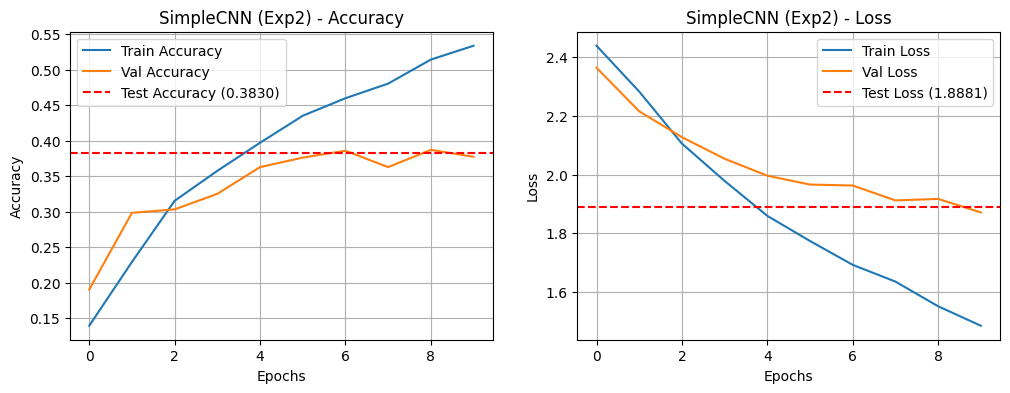

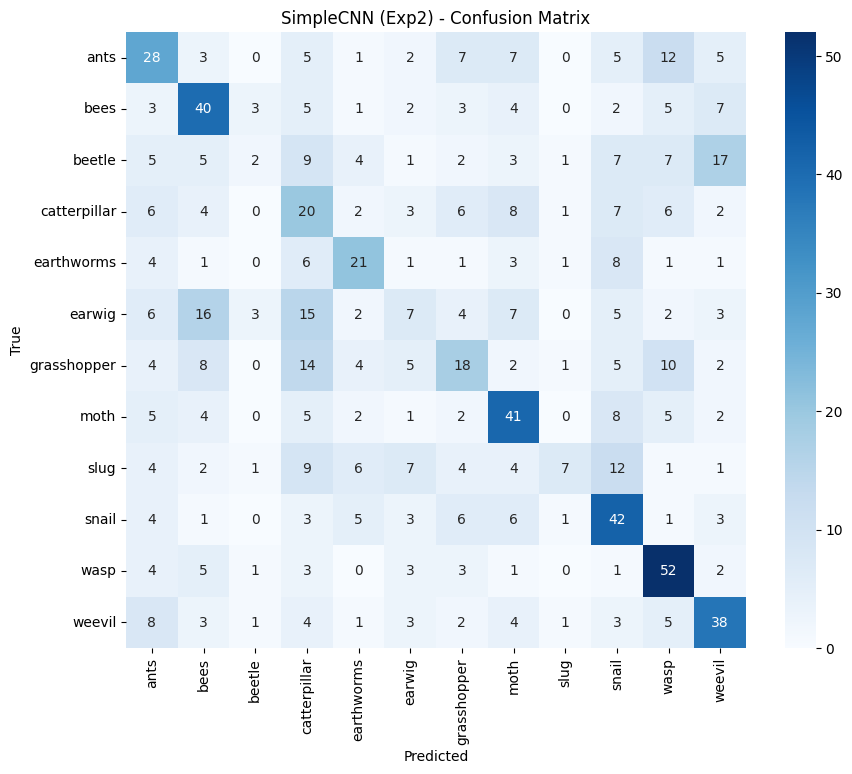

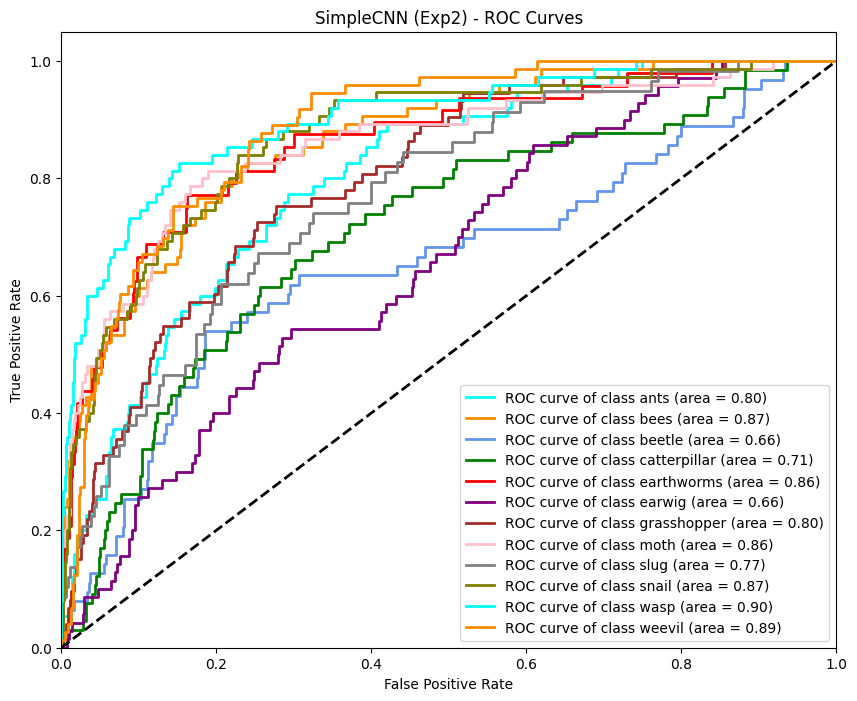

In [ ]:
print("\n--- Training Simple CNN (Exp2) ---")
cnn2 = create_simple_cnn(input_shape, num_classes)
cnn2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = cnn2.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss2, acc2 = cnn2.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba2 = cnn2.predict(X_test_dl)
preds2 = np.argmax(preds_proba2, axis=1)
print("Simple CNN - Experiment 2 Test Results:")
print(f"Loss: {loss2:.4f}, Accuracy: {acc2:.4f}, Precision: {precision_score(y_test_dl_final, preds2, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds2, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds2, average='weighted'):.4f}")
plot_learning_curves(history2, 'SimpleCNN', 'Exp2', test_metrics={'accuracy': acc2, 'loss': loss2})
plot_confusion_matrix(y_test_dl_final, preds2, 'SimpleCNN', 'Exp2')
plot_roc_curves(y_test_dl_final, preds_proba2, 'SimpleCNN', 'Exp2', num_classes)

# 7. Deep Learning Models Custom CNN Experiment 9

In [ ]:
def create_custom_cnn(input_shape, num_classes):
    return Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'), MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'), MaxPooling2D((2, 2)),
        Flatten(), Dense(256, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')
    ])


--- Training Custom CNN (Exp1) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 116s 946ms/step - accuracy: 0.0851 - loss: 2.5494 - val_accuracy: 0.1117 - val_loss: 2.4627
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 117s 966ms/step - accuracy: 0.1425 - loss: 2.4411 - val_accuracy: 0.2306 - val_loss: 2.2864
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 143s 972ms/step - accuracy: 0.2289 - loss: 2.2361 - val_accuracy: 0.3167 - val_loss: 2.0680
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 141s 964ms/step - accuracy: 0.3379 - loss: 2.0036 - val_accuracy: 0.3726 - val_loss: 1.9081
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 114s 940ms/step - accuracy: 0.3973 - loss: 1.8000 - val_accuracy: 0.3592 - val_loss: 1.9022
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 144s 959ms/step - accuracy: 0.4628 - loss: 1.5859 - val_accuracy: 0.3847 - val_loss: 1.8608
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 138s 930ms/step - accuracy: 0.5695 - loss: 1.2898 - val_accuracy: 0.4150 - val_loss: 1.8233
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 116s 963ms/step - accuracy: 0.6588 -

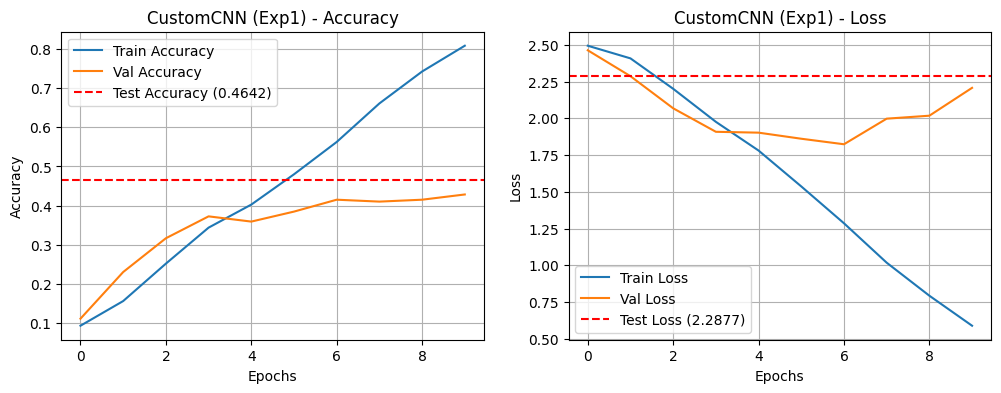

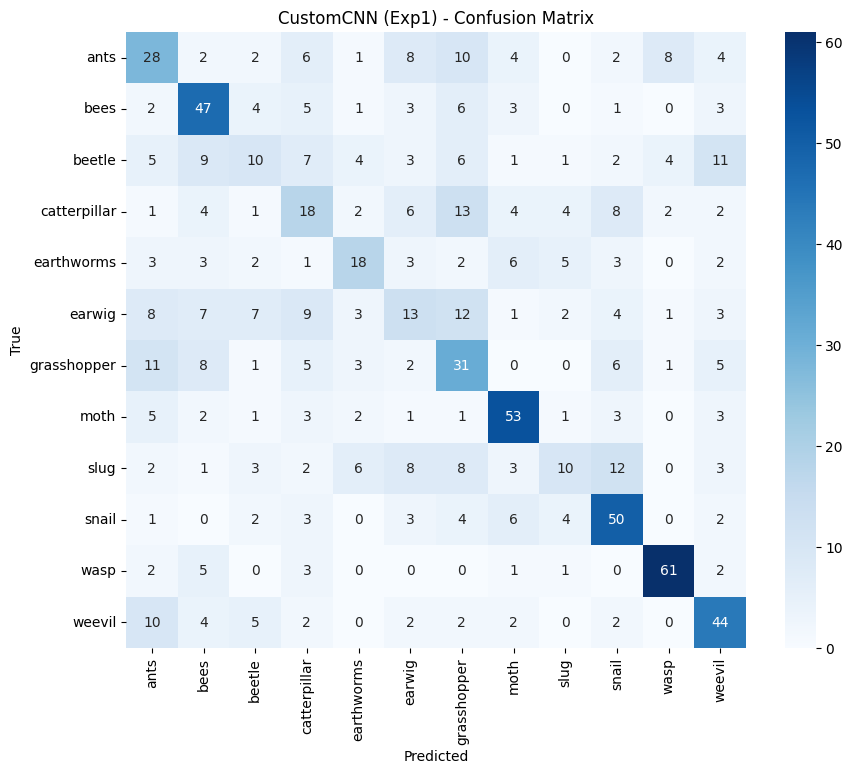

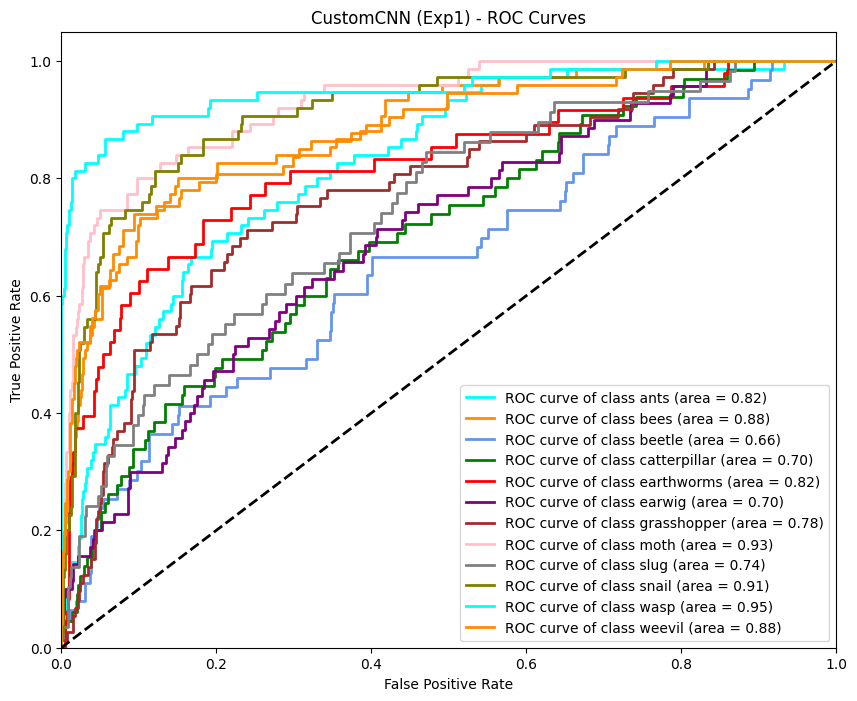

In [ ]:
# --- Custom CNN ---
# Experiment 1
print("\n--- Training Custom CNN (Exp1) ---")
custom_cnn1 = create_custom_cnn(input_shape, num_classes)
custom_cnn1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = custom_cnn1.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss1, acc1 = custom_cnn1.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba1 = custom_cnn1.predict(X_test_dl)
preds1 = np.argmax(preds_proba1, axis=1)
print("Custom CNN - Experiment 1 Test Results:")
print(f"Loss: {loss1:.4f}, Accuracy: {acc1:.4f}, Precision: {precision_score(y_test_dl_final, preds1, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds1, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds1, average='weighted'):.4f}")
plot_learning_curves(history1, 'CustomCNN', 'Exp1', test_metrics={'accuracy': acc1, 'loss': loss1})
plot_confusion_matrix(y_test_dl_final, preds1, 'CustomCNN', 'Exp1')
plot_roc_curves(y_test_dl_final, preds_proba1, 'CustomCNN', 'Exp1', num_classes)

# Deep Learning Models Custom CNN Experiment 10



--- Training Custom CNN (Exp2) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 122s 998ms/step - accuracy: 0.0898 - loss: 2.4925 - val_accuracy: 0.1748 - val_loss: 2.4023
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 141s 987ms/step - accuracy: 0.1924 - loss: 2.3624 - val_accuracy: 0.2731 - val_loss: 2.2311
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 119s 985ms/step - accuracy: 0.2533 - loss: 2.2000 - val_accuracy: 0.3228 - val_loss: 2.0740
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 144s 999ms/step - accuracy: 0.3236 - loss: 2.0352 - val_accuracy: 0.3762 - val_loss: 1.9848
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 116s 955ms/step - accuracy: 0.3608 - loss: 1.9592 - val_accuracy: 0.3774 - val_loss: 1.9353
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 146s 995ms/step - accuracy: 0.3759 - loss: 1.8879 - val_accuracy: 0.4066 - val_loss: 1.8971
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.4147 - loss: 1.7738 - val_accuracy: 0.3568 - val_loss: 1.9699
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4501 - loss:

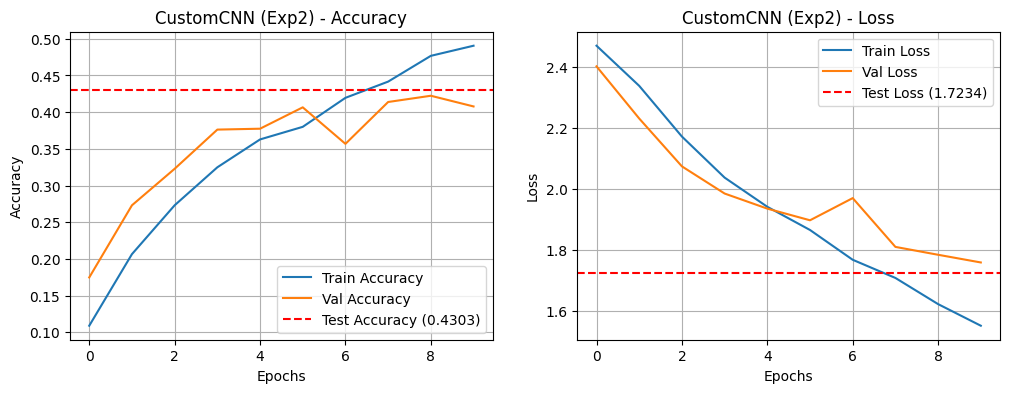

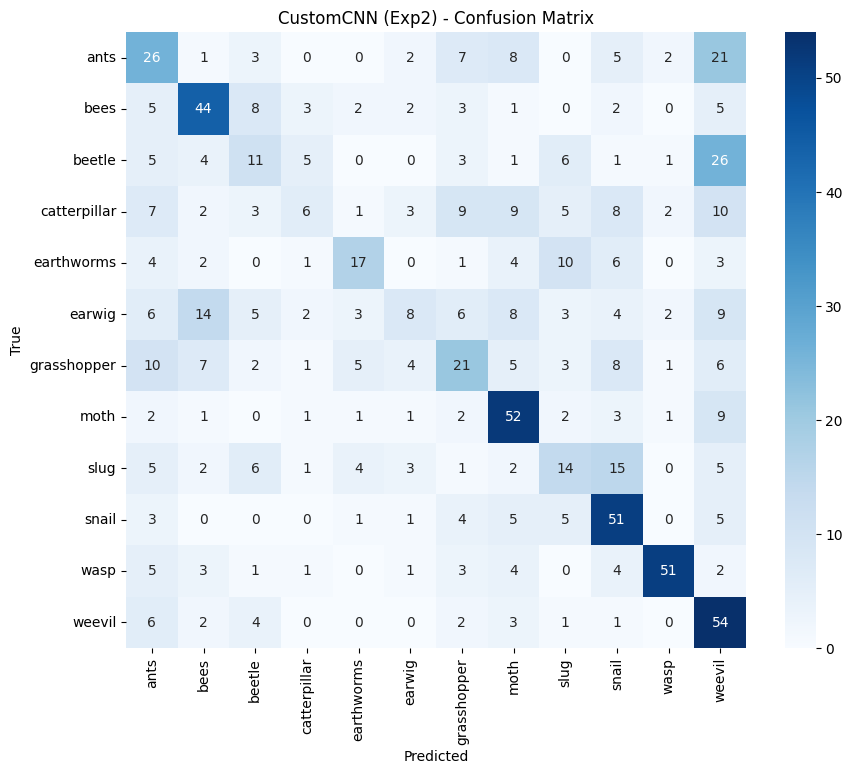

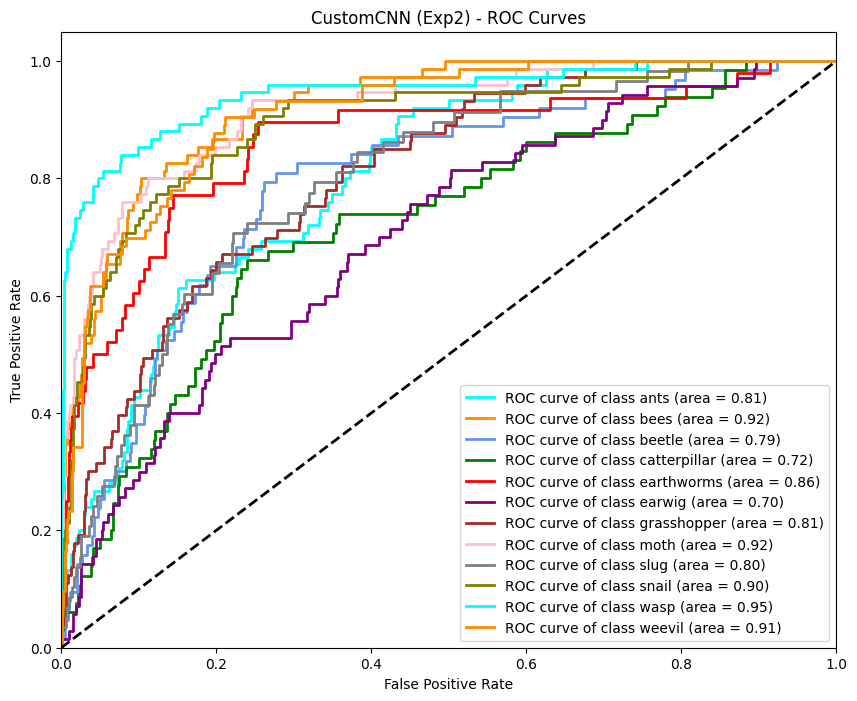

In [ ]:
# Experiment 2
print("\n--- Training Custom CNN (Exp2) ---")
custom_cnn2 = create_custom_cnn(input_shape, num_classes)
custom_cnn2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = custom_cnn2.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss2, acc2 = custom_cnn2.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba2 = custom_cnn2.predict(X_test_dl)
preds2 = np.argmax(preds_proba2, axis=1)
print("Custom CNN - Experiment 2 Test Results:")
print(f"Loss: {loss2:.4f}, Accuracy: {acc2:.4f}, Precision: {precision_score(y_test_dl_final, preds2, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds2, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds2, average='weighted'):.4f}")
plot_learning_curves(history2, 'CustomCNN', 'Exp2', test_metrics={'accuracy': acc2, 'loss': loss2})
plot_confusion_matrix(y_test_dl_final, preds2, 'CustomCNN', 'Exp2')
plot_roc_curves(y_test_dl_final, preds_proba2, 'CustomCNN', 'Exp2', num_classes)

In [ ]:
def create_transfer_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    return Sequential([base_model, Flatten(), Dense(512, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')])

# 9.Deep Learning Models VGG16 Experiment 10



--- Training Transfer Learning (VGG16) (Exp1) ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 967s 8s/step - accuracy: 0.2827 - loss: 2.5876 - val_accuracy: 0.5328 - val_loss: 1.4554
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 911s 8s/step - accuracy: 0.5361 - loss: 1.4139 - val_accuracy: 0.5910 - val_loss: 1.2739
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 964s 8s/step - accuracy: 0.5970 - loss: 1.1641 - val_accuracy: 0.6238 - val_loss: 1.1910
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 952s 8s/step - accuracy: 0.6468 - loss: 1.0287 - val_accuracy: 0.6299 - val_loss: 1.1401
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 907s 8s/step - accuracy: 0.6982 - loss: 0.9029 - val_accuracy: 0.6177 - val_loss: 1.1661
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 966s 8s/step - accuracy: 0.7287 - loss: 0.8293 - val_accuracy: 0.6274 - val_loss: 1.1426
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 905s 7s/step - accuracy: 0.7641 - loss: 0.7074 - val_accuracy: 0.6335 - val_loss: 1.

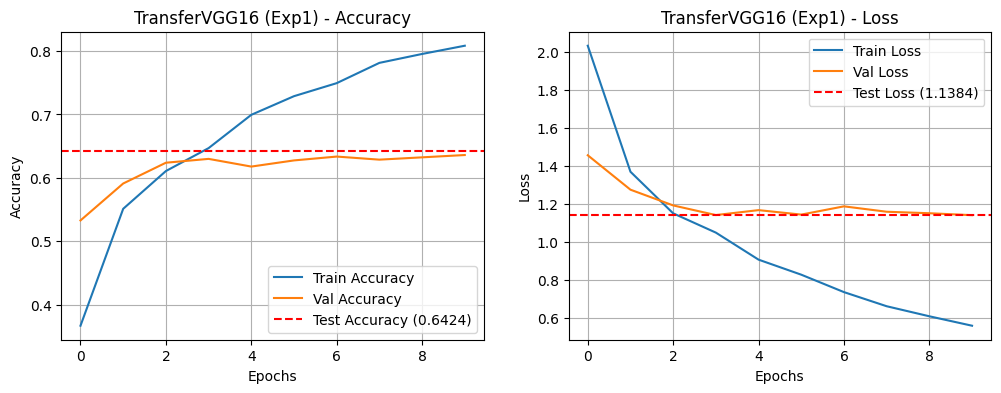

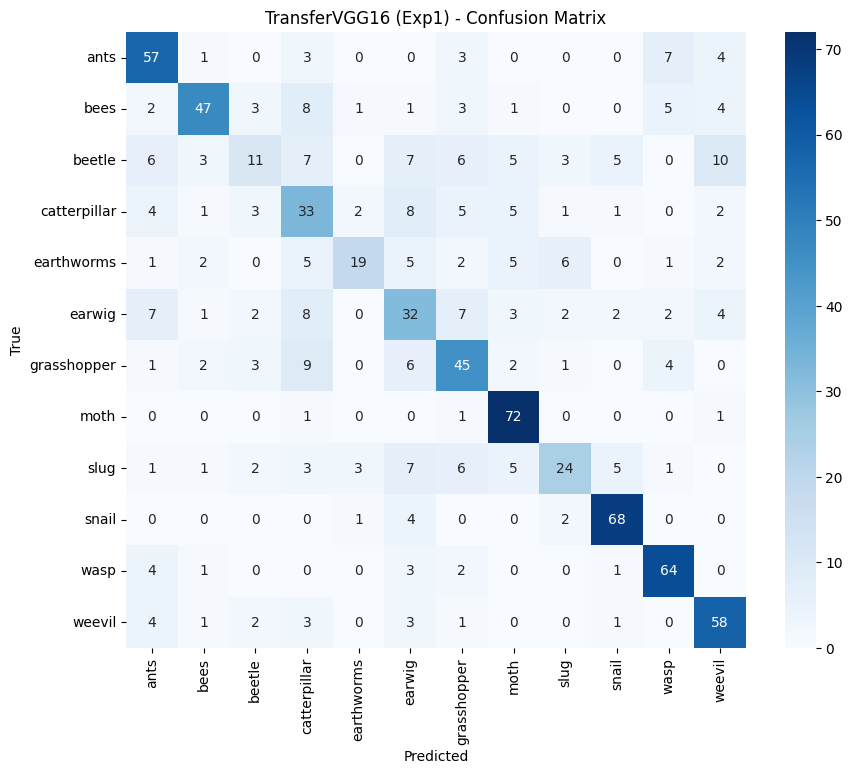

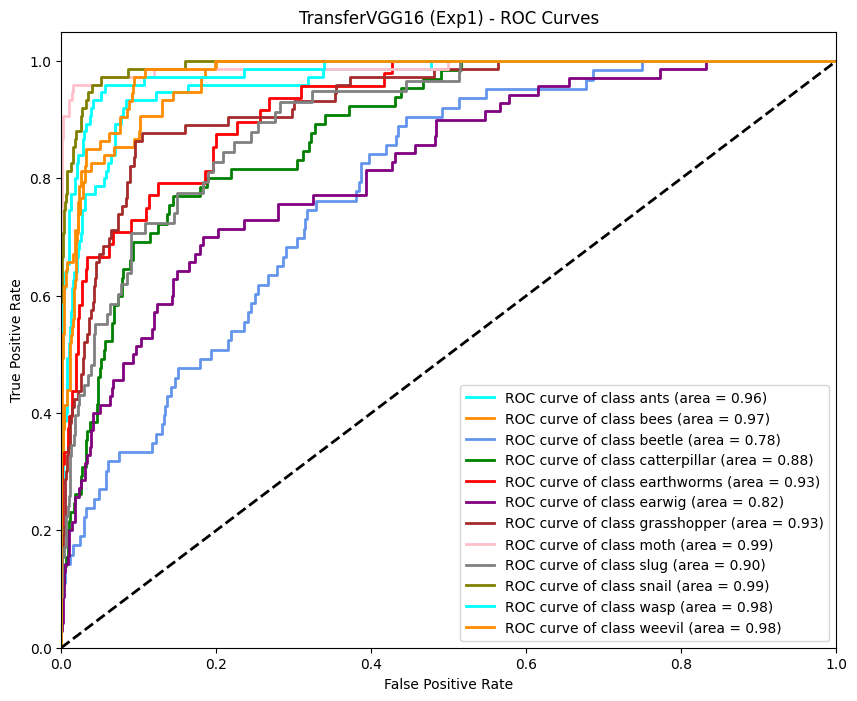

In [ ]:
# --- Transfer Learning (VGG16) ---
# Experiment 1
print("\n--- Training Transfer Learning (VGG16) (Exp1) ---")
transfer_model1 = create_transfer_model(input_shape, num_classes)
transfer_model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = transfer_model1.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss1, acc1 = transfer_model1.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba1 = transfer_model1.predict(X_test_dl)
preds1 = np.argmax(preds_proba1, axis=1)
print("Transfer Learning (VGG16) - Experiment 1 Test Results:")
print(f"Loss: {loss1:.4f}, Accuracy: {acc1:.4f}, Precision: {precision_score(y_test_dl_final, preds1, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds1, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds1, average='weighted'):.4f}")
plot_learning_curves(history1, 'TransferVGG16', 'Exp1', test_metrics={'accuracy': acc1, 'loss': loss1})
plot_confusion_matrix(y_test_dl_final, preds1, 'TransferVGG16', 'Exp1')
plot_roc_curves(y_test_dl_final, preds_proba1, 'TransferVGG16', 'Exp1', num_classes)

# 10.Deep Learning Models VGG16 Experiment 11


--- Training Transfer Learning (VGG16) (Exp2) ---
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 913s 8s/step - accuracy: 0.2321 - loss: 2.3132 - val_accuracy: 0.5158 - val_loss: 1.5862
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 925s 8s/step - accuracy: 0.5128 - loss: 1.5190 - val_accuracy: 0.5558 - val_loss: 1.3577
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 910s 7s/step - accuracy: 0.6027 - loss: 1.2215 - val_accuracy: 0.6007 - val_loss: 1.2510
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 970s 8s/step - accuracy: 0.6654 - loss: 1.0519 - val_accuracy: 0.6141 - val_loss: 1.2082
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 916s 8s/step - accuracy: 0.7105 - loss: 0.9241 - val_accuracy: 0.6214 - val_loss: 1.1538
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 955s 8s/step - accuracy: 0.7416 - loss: 0.8274 - val_accuracy: 0.6141 - val_loss: 1.1241
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 951s 8s/step - accuracy: 0.7711 - loss: 0.7273 - val_accuracy: 0.6493 - val_loss: 1.1055
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1008s 

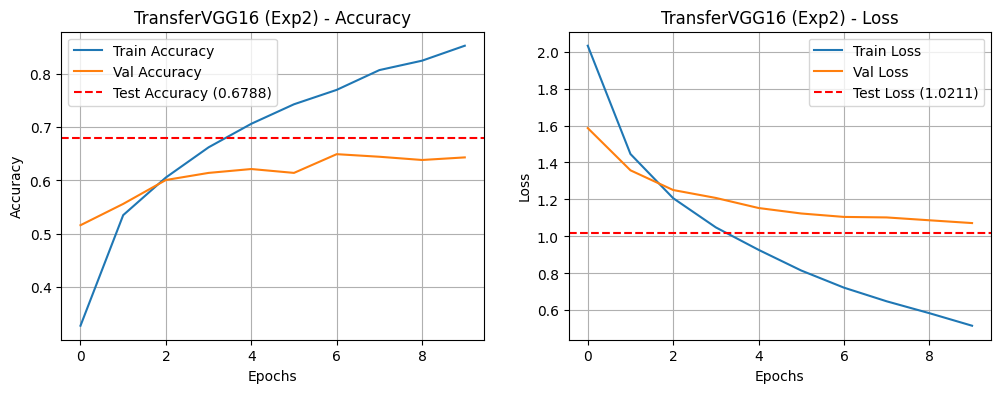

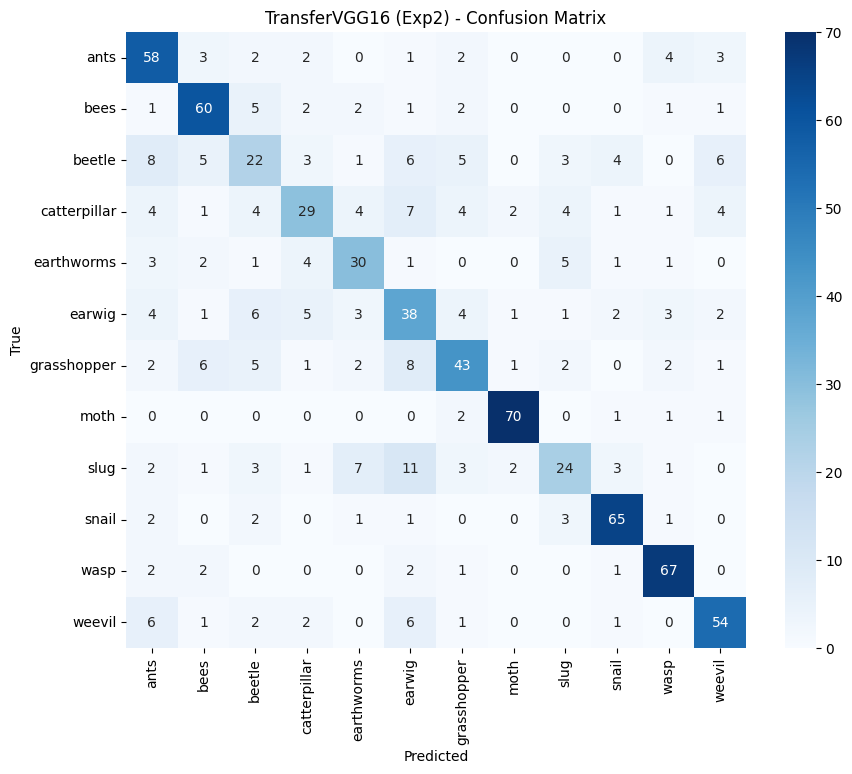

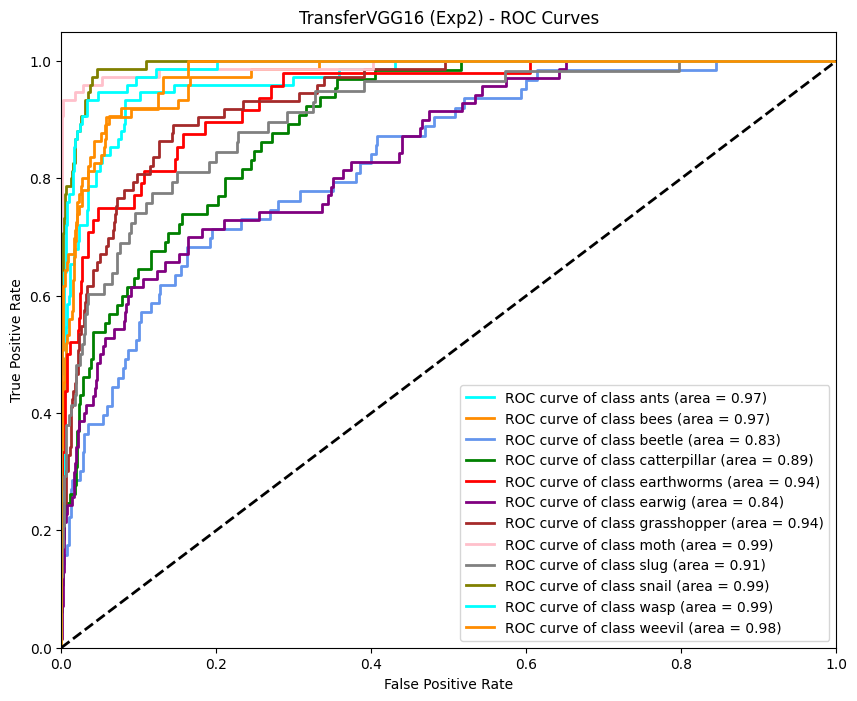

In [ ]:
# Experiment 2
print("\n--- Training Transfer Learning (VGG16) (Exp2) ---")
transfer_model2 = create_transfer_model(input_shape, num_classes)
transfer_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = transfer_model2.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss2, acc2 = transfer_model2.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba2 = transfer_model2.predict(X_test_dl)
preds2 = np.argmax(preds_proba2, axis=1)
print("Transfer Learning (VGG16) - Experiment 2 Test Results:")
print(f"Loss: {loss2:.4f}, Accuracy: {acc2:.4f}, Precision: {precision_score(y_test_dl_final, preds2, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds2, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds2, average='weighted'):.4f}")
plot_learning_curves(history2, 'TransferVGG16', 'Exp2', test_metrics={'accuracy': acc2, 'loss': loss2})
plot_confusion_matrix(y_test_dl_final, preds2, 'TransferVGG16', 'Exp2')
plot_roc_curves(y_test_dl_final, preds_proba2, 'TransferVGG16', 'Exp2', num_classes)

# 10.Deep Learning Models MobileNetV2 Experiment 10

In [ ]:
def create_transfer_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    return Sequential([base_model, Flatten(), Dense(512, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')])


--- Training Transfer Learning (MobileNetV2) (Exp1) ---


/tmp/ipython-input-2243361772.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4426 - loss: 8.9880 - val_accuracy: 0.7100 - val_loss: 0.9541
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6329 - loss: 1.1661 - val_accuracy: 0.7245 - val_loss: 0.8425
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6850 - loss: 0.9747 - val_accuracy: 0.7330 - val_loss: 0.7865
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7321 - loss: 0.8155 - val_accuracy: 0.7391 - val_loss: 0.7621
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7394 - loss: 0.7795 - val_accuracy: 0.7282 - val_loss: 0.8159
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7561 - loss: 0.7281 - val_accuracy: 0.7561 - val_loss: 0.8009
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7658 - loss: 0.6664 - val_accuracy: 0.7779 - val_loss: 0.7042
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7915 - loss: 0.6184 - val_accu

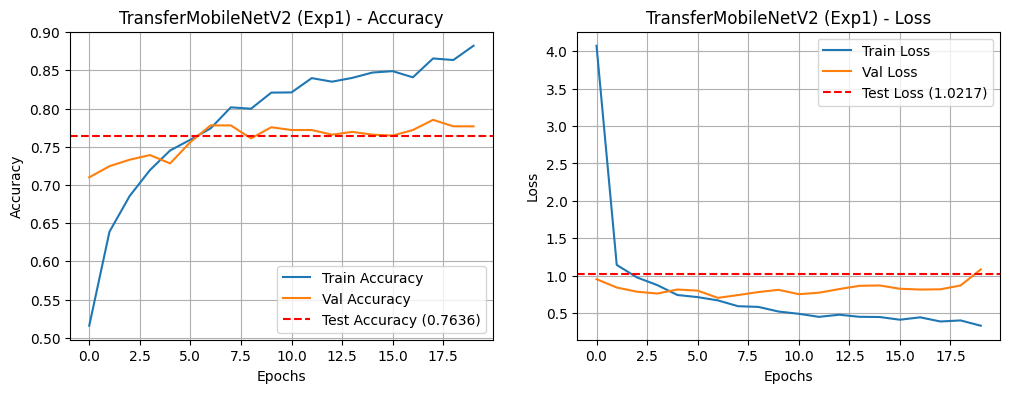

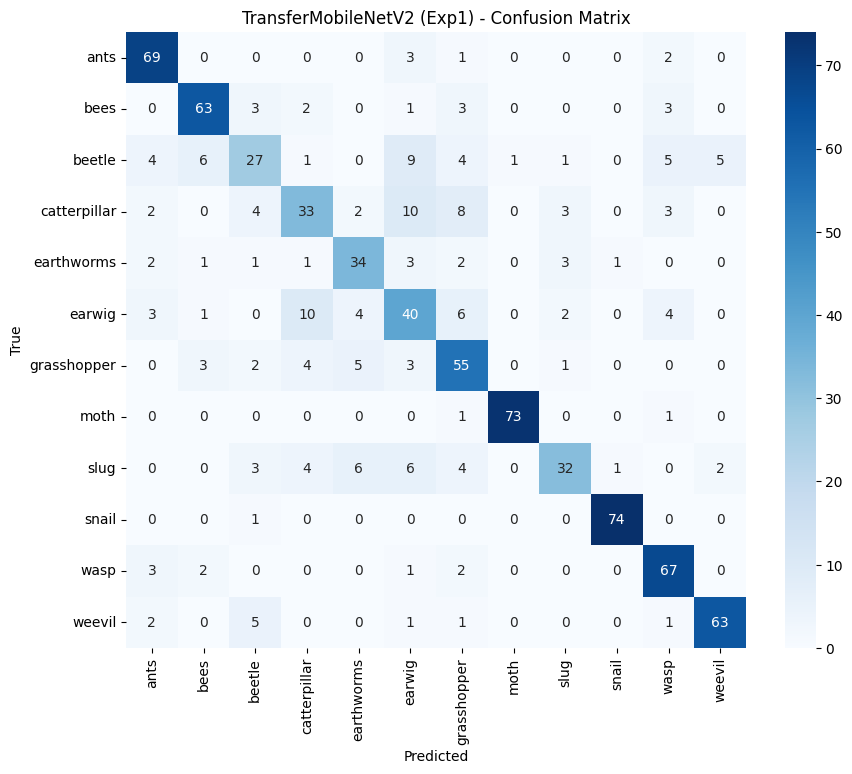

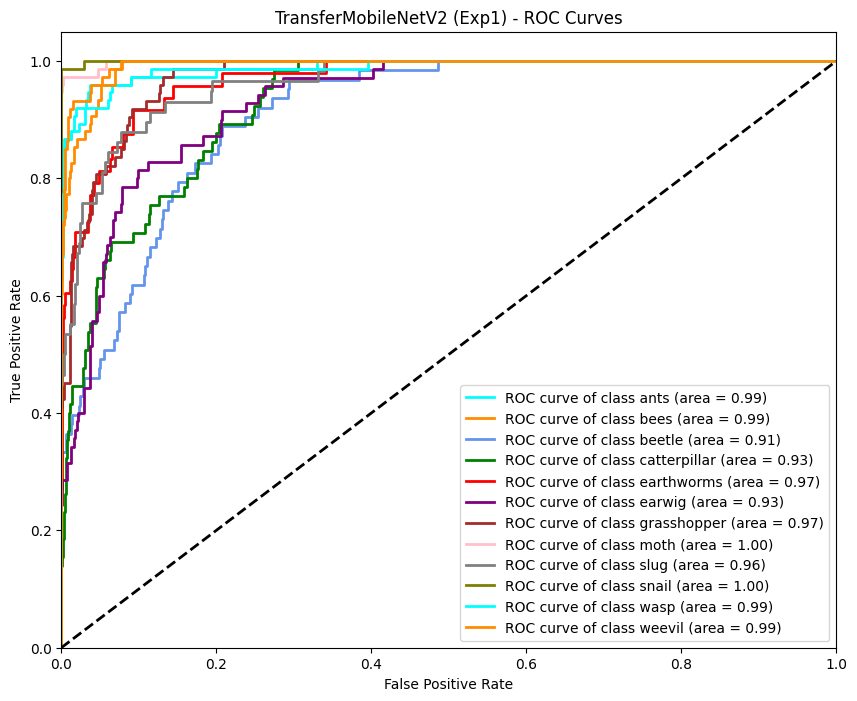

In [ ]:
# 5. Deep Learning Models
input_shape = X_train[0].shape
num_classes = len(class_names)
y_train_cat = to_categorical(y_train_dl, num_classes)
y_val_cat = to_categorical(y_val_dl, num_classes)
y_test_cat = to_categorical(y_test_dl_final, num_classes)

def create_transfer_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    return Sequential([base_model, Flatten(), Dense(512, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')])

# --- Transfer Learning (MobileNetV2) ---
# Experiment 1
print("\n--- Training Transfer Learning (MobileNetV2) (Exp1) ---")
transfer_model_mb1 = create_transfer_mobilenet_model(input_shape, num_classes)
transfer_model_mb1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_mb1 = transfer_model_mb1.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss_mb1, acc_mb1 = transfer_model_mb1.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba_mb1 = transfer_model_mb1.predict(X_test_dl)
preds_mb1 = np.argmax(preds_proba_mb1, axis=1)
print("Transfer Learning (MobileNetV2) - Experiment 1 Test Results:")
print(f"Loss: {loss_mb1:.4f}, Accuracy: {acc_mb1:.4f}, Precision: {precision_score(y_test_dl_final, preds_mb1, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds_mb1, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds_mb1, average='weighted'):.4f}")
plot_learning_curves(history_mb1, 'TransferMobileNetV2', 'Exp1', test_metrics={'accuracy': acc_mb1, 'loss': loss_mb1})
plot_confusion_matrix(y_test_dl_final, preds_mb1, 'TransferMobileNetV2', 'Exp1')
plot_roc_curves(y_test_dl_final, preds_proba_mb1, 'TransferMobileNetV2', 'Exp1', num_classes)



# Deep Learning Models MobileNetV2 Experiment 11


--- Training Transfer Learning (MobileNetV2) (Exp2) ---


/tmp/ipython-input-2495839456.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.4893 - loss: 2.4184 - val_accuracy: 0.7718 - val_loss: 0.7166
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7979 - loss: 0.6195 - val_accuracy: 0.7609 - val_loss: 0.7172
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8524 - loss: 0.4236 - val_accuracy: 0.7913 - val_loss: 0.6333
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9102 - loss: 0.2613 - val_accuracy: 0.7937 - val_loss: 0.6665
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9178 - loss: 0.2408 - val_accuracy: 0.7852 - val_loss: 0.6852
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9612 - loss: 0.1129 - val_accuracy: 0.7816 - val_loss: 0.6960
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9759 - loss: 0.0776 - val_accuracy: 0.7973 - val_loss: 0.7403
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 121s 998ms/step - accuracy: 0.9741 - loss: 0.0806 - val_a

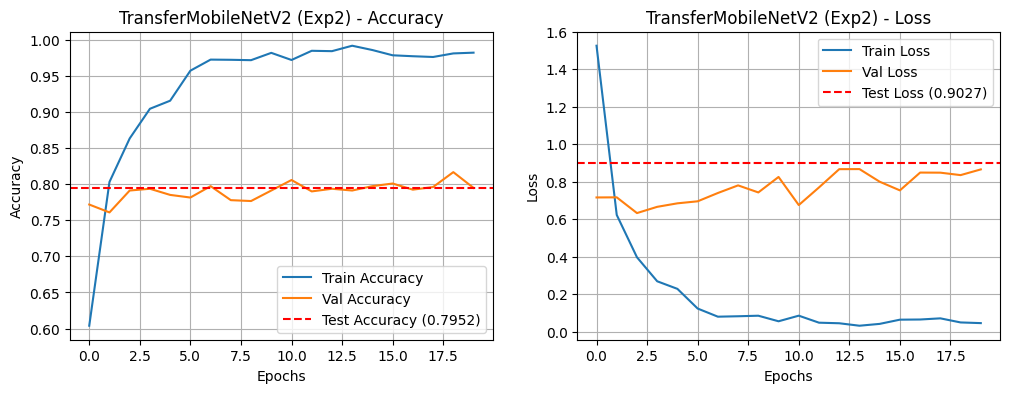

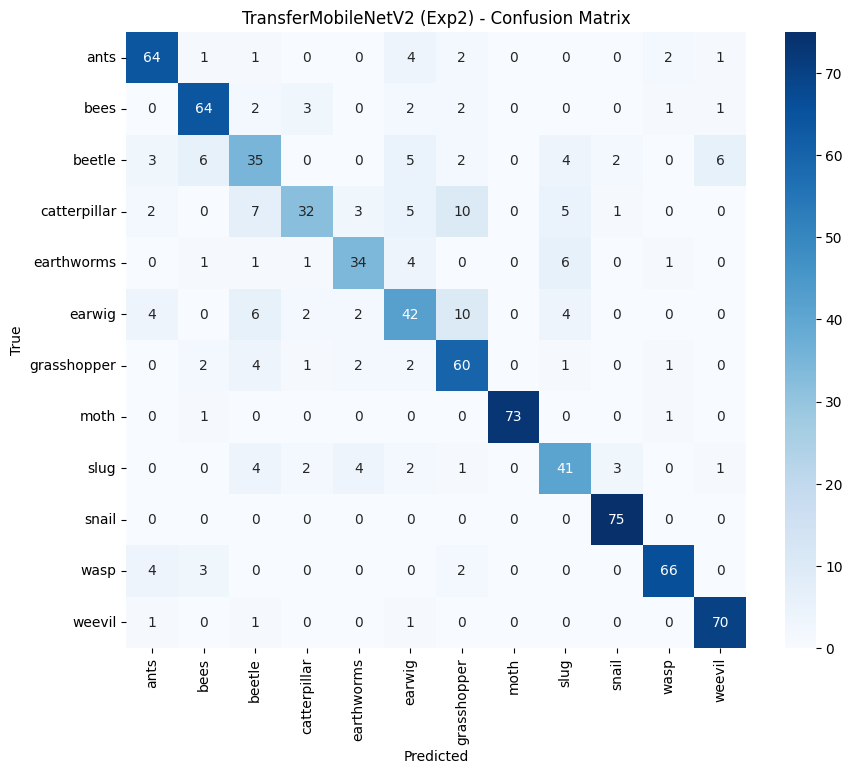

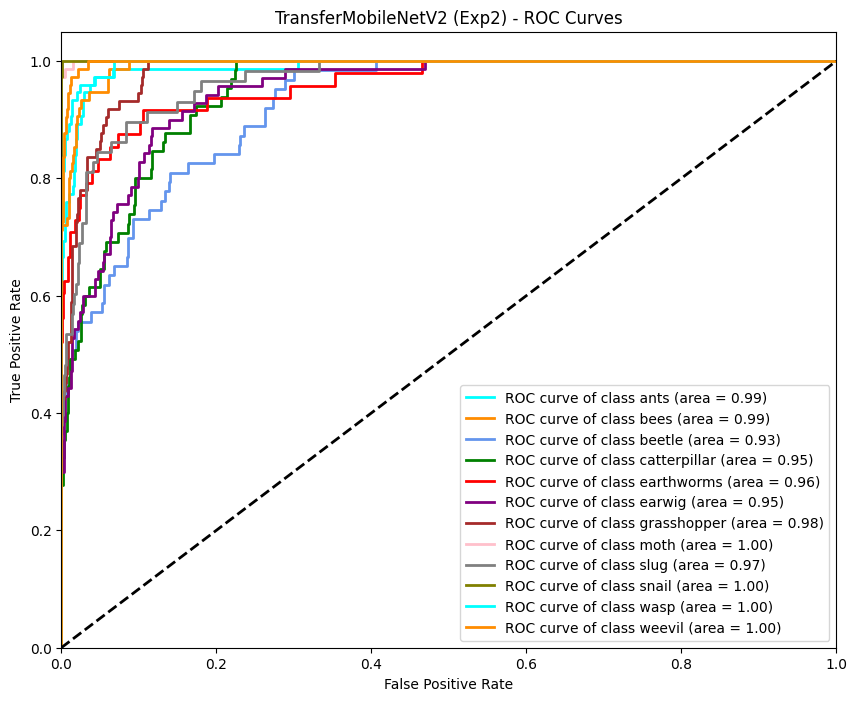

In [ ]:
# Experiment 2
print("\n--- Training Transfer Learning (MobileNetV2) (Exp2) ---")
transfer_model_mb2 = create_transfer_mobilenet_model(input_shape, num_classes)
transfer_model_mb2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_mb2 = transfer_model_mb2.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss_mb2, acc_mb2 = transfer_model_mb2.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba_mb2 = transfer_model_mb2.predict(X_test_dl)
preds_mb2 = np.argmax(preds_proba_mb2, axis=1)
print("Transfer Learning (MobileNetV2) - Experiment 2 Test Results:")
print(f"Loss: {loss_mb2:.4f}, Accuracy: {acc_mb2:.4f}, Precision: {precision_score(y_test_dl_final, preds_mb2, average='weighted'):.4f}, Recall: {recall_score(y_test_dl_final, preds_mb2, average='weighted'):.4f}, F1-score: {f1_score(y_test_dl_final, preds_mb2, average='weighted'):.4f}")
plot_learning_curves(history_mb2, 'TransferMobileNetV2', 'Exp2', test_metrics={'accuracy': acc_mb2, 'loss': loss_mb2})
plot_confusion_matrix(y_test_dl_final, preds_mb2, 'TransferMobileNetV2', 'Exp2')
plot_roc_curves(y_test_dl_final, preds_proba_mb2, 'TransferMobileNetV2', 'Exp2', num_classes)

# Deep Learning Models MobileNetV2 Experiment 12


--- Training Transfer Learning (MobileNetV2) with Data Augmentation (Exp3) ---


/tmp/ipython-input-3549298551.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3327 - loss: 2.6230 - val_accuracy: 0.6966 - val_loss: 0.8889 - learning_rate: 1.0000e-04
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5312 - loss: 1.3336 - val_accuracy: 0.6966 - val_loss: 0.8847 - learning_rate: 1.0000e-04
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 174s 955ms/step - accuracy: 0.5861 - loss: 1.3018 - val_accuracy: 0.7439 - val_loss: 0.7647 - learning_rate: 1.0000e-04
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4688 - loss: 1.4736 - val_accuracy: 0.7391 - val_loss: 0.7700 - learning_rate: 1.0000e-04
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 115s 958ms/step - accuracy: 0.6297 - loss: 1.1732 - val_accuracy: 0.7585 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.6250 - loss: 1.2870 - val_accuracy: 0.7561 - val_loss: 0.7261 - learning_rate: 1.0000e-04
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 119s 9

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.5000 - loss: 1.1566 - val_accuracy: 0.7791 - val_loss: 0.6471 - learning_rate: 1.0000e-04
Epoch 17/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7182 - loss: 0.8945 - val_accuracy: 0.7852 - val_loss: 0.6124 - learning_rate: 1.0000e-04
Epoch 18/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.5000 - loss: 1.3279 - val_accuracy: 0.7876 - val_loss: 0.6189 - learning_rate: 1.0000e-04
Epoch 19/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7245 - loss: 0.8812 - val_accuracy: 0.7888 - val_loss: 0.6443 - learning_rate: 1.0000e-04
Epoch 20/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.6562 - loss: 0.8571 - val_accuracy: 0.7876 - val_loss: 0.6442 - learning_rate: 1.0000e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 623ms/step

--- Experiment 3 Test Results ---
Loss: 0.6503
Accuracy: 0.7891
Precision: 0.7836
Recall: 0.7891
F1-score: 0.7791


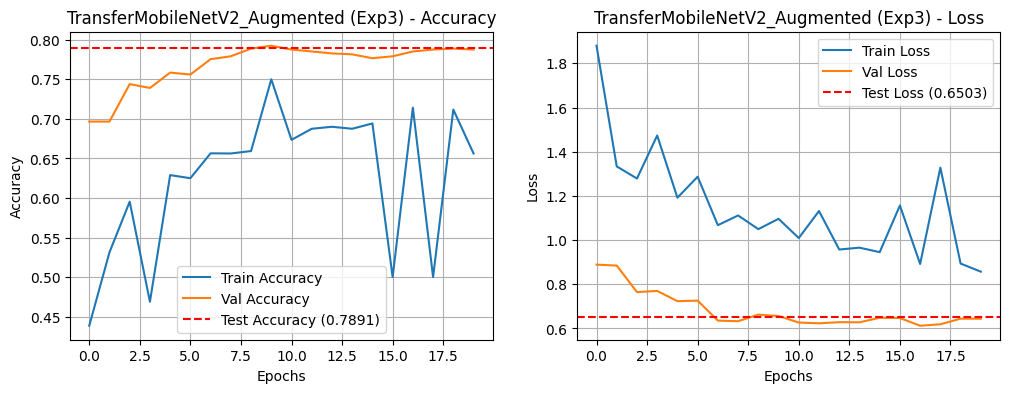

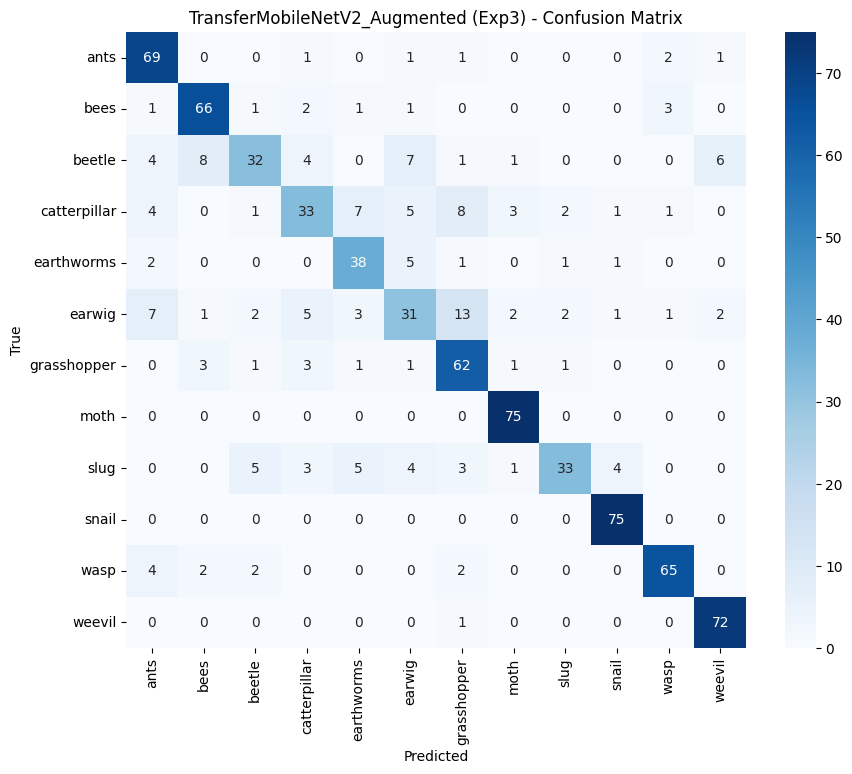

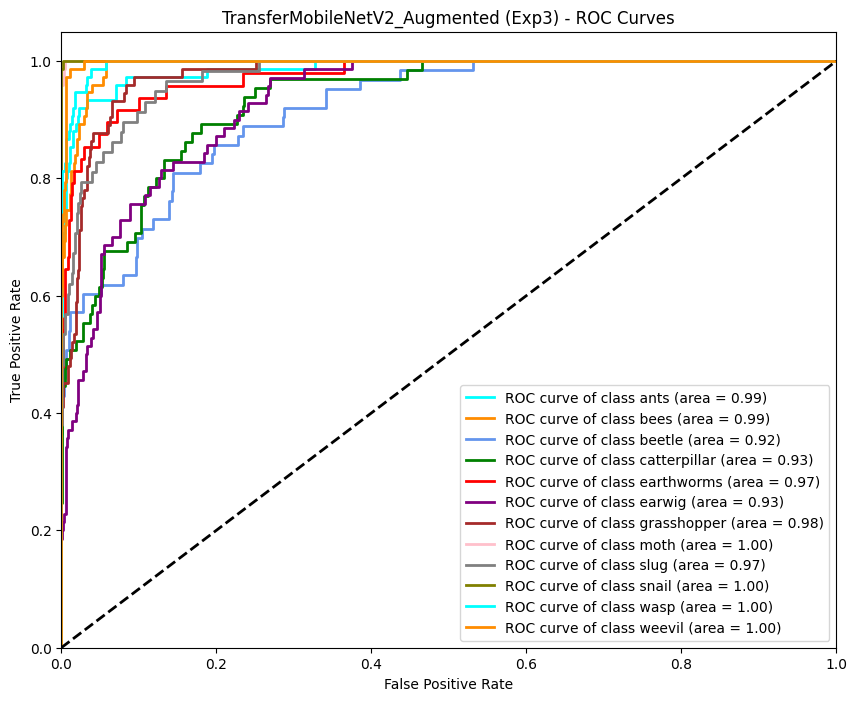

In [ ]:
# --- Experiment 3: MobileNetV2 with Data Augmentation and Callbacks ---
print("\n--- Training Transfer Learning (MobileNetV2) with Data Augmentation (Exp3) ---")

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Model Creation and Compilation
transfer_model_mb3 = create_transfer_mobilenet_model(input_shape, num_classes)
transfer_model_mb3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training
history_mb3 = transfer_model_mb3.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluation
loss_mb3, acc_mb3 = transfer_model_mb3.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba_mb3 = transfer_model_mb3.predict(X_test_dl)
preds_mb3 = np.argmax(preds_proba_mb3, axis=1)

print("\n--- Experiment 3 Test Results ---")
print(f"Loss: {loss_mb3:.4f}")
print(f"Accuracy: {acc_mb3:.4f}")
print(f"Precision: {precision_score(y_test_dl_final, preds_mb3, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_dl_final, preds_mb3, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_dl_final, preds_mb3, average='weighted'):.4f}")

# Plotting Results
plot_learning_curves(history_mb3, 'TransferMobileNetV2_Augmented', 'Exp3', test_metrics={'accuracy': acc_mb3, 'loss': loss_mb3})
plot_confusion_matrix(y_test_dl_final, preds_mb3, 'TransferMobileNetV2_Augmented', 'Exp3')
plot_roc_curves(y_test_dl_final, preds_proba_mb3, 'TransferMobileNetV2_Augmented', 'Exp3', num_classes)

# Deep Learning Models MobileNetV2 Experiment 13

In [ ]:
# --- Data Augmentation and Callbacks (Exp4) ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


--- Training Transfer Learning (MobileNetV2) with Fine-Tuning (Exp4) ---


/tmp/ipython-input-3947246093.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training the classifier head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.4013 - loss: 2.6691 - val_accuracy: 0.7100 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6149 - loss: 1.2003 - val_accuracy: 0.7706 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6528 - loss: 1.1095 - val_accuracy: 0.7852 - val_loss: 0.6503 - learning_rate: 1.0000e-04
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.6659 - loss: 1.0569 - val_accuracy: 0.7573 - val_loss: 0.6645 - learning_rate: 1.0000e-04
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6909 - loss: 0.9699 - val_accuracy: 0.7791 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7076 - loss: 0.8678 - val_accuracy: 0.7779 - val_loss: 0.6357 - learning_rate: 1.0000e-04
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - acc

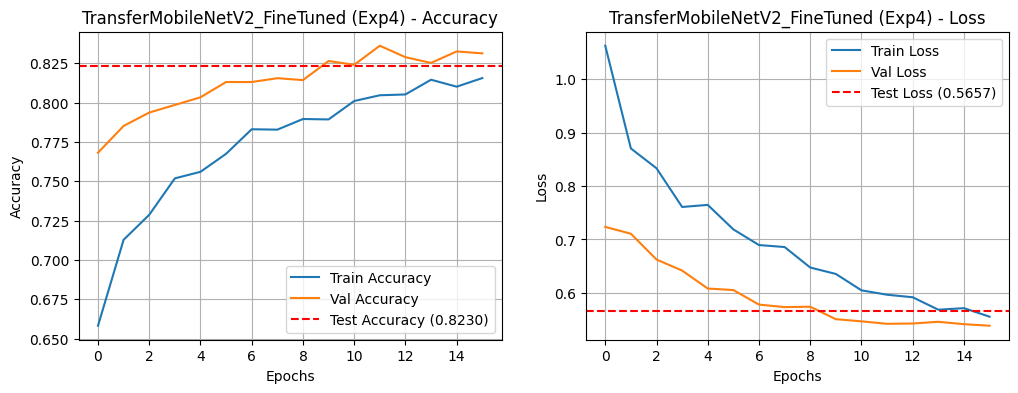

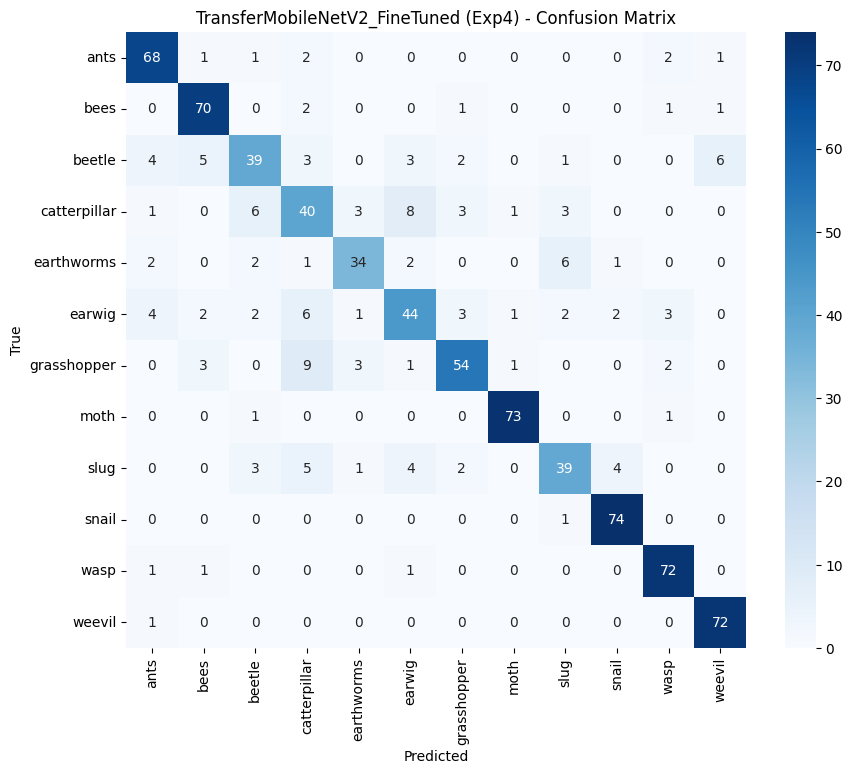

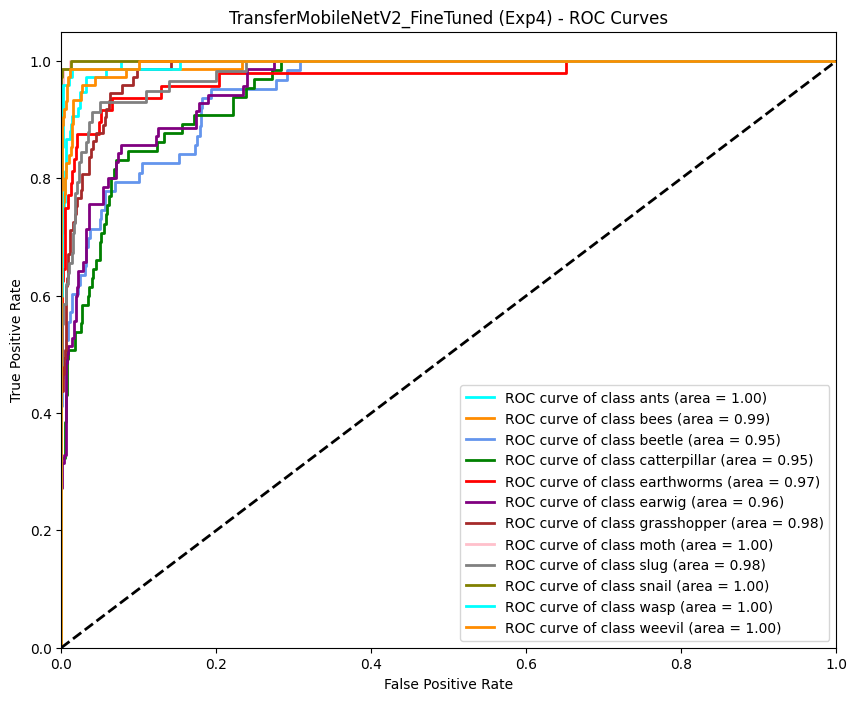


Script finished. Plots are saved in the 'output' directory.


In [ ]:
# --- Experiment 4: Fine-Tuning the MobileNetV2 Model ---
print("\n--- Training Transfer Learning (MobileNetV2) with Fine-Tuning (Exp4) ---")

# For fine-tuning, it's best to first train the classifier head and then unfreeze the base model.
# This experiment will be self-contained and perform both steps.

# Step 1: Create a new model for this experiment
finetune_model = create_transfer_mobilenet_model(input_shape, num_classes)

# Step 2: Train the top layer (the classifier)
print("\nPhase 1: Training the classifier head")
finetune_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train for a number of epochs to stabilize the classifier weights
head_epochs = 15
history_phase1 = finetune_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=int(np.ceil(len(X_train) / BATCH_SIZE)),
    epochs=head_epochs,
    callbacks=[early_stopping, reduce_lr], # Use original callbacks for this phase
    verbose=1
)

# Step 3: Unfreeze the base model and fine-tune
print("\nPhase 2: Fine-tuning the model")
base_model = finetune_model.layers[0]
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100  # Unfreeze the top 54 layers

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning
finetune_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(f"Fine-tuning model by unfreezing top {len(base_model.layers) - fine_tune_at} layers.")

# Continue training for more epochs to fine-tune the unfrozen layers
fine_tune_epochs = 15
total_epochs = head_epochs + fine_tune_epochs

history_mb4 = finetune_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=int(np.ceil(len(X_train) / BATCH_SIZE)),
    epochs=total_epochs,
    initial_epoch=history_phase1.epoch[-1], # Start counting epochs after the head training
    callbacks=[early_stopping, reduce_lr], # Can reuse the same callbacks
    verbose=1
)

# Evaluation
loss_mb4, acc_mb4 = finetune_model.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba_mb4 = finetune_model.predict(X_test_dl)
preds_mb4 = np.argmax(preds_proba_mb4, axis=1)

print("\n--- Experiment 4 (Fine-Tuning) Test Results ---")
print(f"Loss: {loss_mb4:.4f}")
print(f"Accuracy: {acc_mb4:.4f}")
print(f"Precision: {precision_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")

# Plotting Results
plot_learning_curves(history_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4', test_metrics={'accuracy': acc_mb4, 'loss': loss_mb4})
plot_confusion_matrix(y_test_dl_final, preds_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4')
plot_roc_curves(y_test_dl_final, preds_proba_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4', num_classes)

print("\nScript finished. Plots are saved in the 'output' directory.")